# Parse scVI results and generate figures

This notebook reproduces the figures for the manuscript `Quantifying the tradeoff between sequencing depth and cell number in sincle-cell RNA-seq`

It can be readily modifies to generate the same figures for other datasets

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from glob import glob
import statsmodels.formula.api as smf
import anndata
import pandas as pd
from scipy import io
from scipy import sparse
from tqdm import tqdm, tqdm_notebook
from matplotlib import colors
import matplotlib.patheffects as path_effects
import plotnine as p
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
# choose output folder to save figures
figfolder = './figures/'

if not os.path.isdir(figfolder): 
    os.makedirs(figfolder)

# Add total reads and cells metadata about the datasets

In [3]:
# create a small dataframe to hold total number of reads in datasets, reference name, and number of cells 
# if all file structures for the new dataset are consistent, the rest of the notebook should not need to be modified
datasets = ['heart10k', 'neurons10k','pbmc10k']

# create ddf -> dataset dataframe
ddf = pd.DataFrame()
ddf['ds']= ['heart10k', 'neurons10k','pbmc10k']

ddf.index=ddf['ds'].values

cluster_files = {
'heart10k' :'./heart10k_clusters.csv',    
'pbmc10k' :'./pbmc10k_clusters.csv',    
'neurons10k' :'./neurons10k_clusters.csv',     
}


scvi_output_folders = {
'heart10k' :'./scvi_output_heart10k/*',    
'pbmc10k' :'./scvi_output_pbmc10k/*',    
'neurons10k' :'./scvi_output_neurons10k/*',     
}

adata_files = {
'heart10k' :'./heart10k_subsamples.h5ad',    
'pbmc10k' :'./pbmc10k_subsamples.h5ad',    
'neurons10k' :'./neurons10k_subsamples.h5ad',     
}

ddf['total_cells'] = [pd.read_csv(cluster_files[dataset]).shape[0] for dataset in ddf['ds'].values]
ddf['total_reads_in_dataset'] = ddf['ds'].map({
                          'heart10k': 290439571, 
                          'neurons10k': 357111595,
                          'pbmc10k':638901019,
                          })
ddf

ds  total_cells  total_reads_in_dataset
heart10k      heart10k         7713               290439571
neurons10k  neurons10k        11843               357111595
pbmc10k        pbmc10k        11769               638901019

# Create summary results (one entry per sampled point)

In [4]:
# parse scVI csv results to create a summary of results: one entry per pair of 
# cells (sampled_cells) and number of sampled reads (total_seqtk_reads)

summary_results={}

# total_seqtk_reads: the number of reads in the fastq file produces by seqtk which was processed with kallisto
# total_cells: number of cells in dataset as reported by 10x
# sampled cells: number of cells used for training scVI
# reads_per_cell: total_seqtk_reads/total_cells
# estimated_reads: estimated total number of reads for the cells used by scVI



for ds in ddf['ds']:
    dfs = []

    for fname in tqdm(glob(scvi_output_folders[ds])):
        df = pd.read_csv(fname, nrows=1)
        dfs.append(df)
    
    summary_results[ds] = pd.concat(dfs).reset_index(drop=True)
    summary_results[ds]['UMIs'] = 0 

    #loads anndata object used for calculating UMIs seen
    adata = anndata.read(adata_files[ds])
    total_cells = adata.n_obs
    
    # this uses the anndata object to calculate the total UMIs for each subsampling depth
    for subsampled_depth in summary_results[ds]['ss_depth'].unique():
        total_UMIs = int(adata.layers[str(subsampled_depth)].sum())
        summary_results[ds].loc[summary_results[ds].ss_depth == subsampled_depth, 'total_UMIs'] = total_UMIs
#         print(subsampled_depth, total_UMIs)
    
    # rfull data depth from `0` to the total reads in the dataset,
    summary_results[ds]['ss_depth'] = summary_results[ds]['ss_depth'].map(lambda d: {0: ddf.loc[ds]['total_reads_in_dataset']}.get(d, d))
    # we rename ss_depth to total_seqtk_reads to avoid abiguity
    summary_results[ds].rename(columns={'ss_depth':'total_seqtk_reads'}, inplace=True)
    summary_results[ds].rename(columns={'ss_cells':'sampled_cells'}, inplace=True)
    summary_results[ds]['validation_error'] = summary_results[ds]['validation_error'].round(1)

    summary_results[ds]['estimated_reads'] = (summary_results[ds]['sampled_cells'] / ddf.loc[ds]['total_cells'] * summary_results[ds]['total_seqtk_reads']).astype('int')
    summary_results[ds]['reads_per_cell'] = (summary_results[ds]['total_seqtk_reads'] / ddf.loc[ds]['total_cells']).astype('int')
    
    summary_results[ds]['estimated_UMIs'] = (summary_results[ds]['sampled_cells'] / ddf.loc[ds]['total_cells'] * summary_results[ds]['total_UMIs']).astype('int')
    summary_results[ds]['UMIs_per_cell'] = (summary_results[ds]['total_UMIs'] / ddf.loc[ds]['total_cells']).astype('int')
    summary_results[ds].drop(['tsne_0', 'tsne_1', 'index'], axis=1, inplace=True)
    summary_results[ds].index.rename(ds, inplace=True)
    print(ds, 'summary results shape:' , summary_results[ds].shape)
    print('Number of points with missing validation errors: ', sum(summary_results[ds]['validation_error'].isna()) )
    
    display(summary_results[ds].head(2))


100%|██████████| 250/250 [00:01<00:00, 126.39it/s]


heart10k summary results shape: (250, 9)
Number of points with missing validation errors:  77


total_seqtk_reads  sampled_cells  validation_error  UMIs  \
heart10k                                                             
0                   1600000           2817           21986.1     0   
1                 204800000           1409            1646.2     0   

          total_UMIs  estimated_reads  reads_per_cell  estimated_UMIs  \
heart10k                                                                
0           673164.0           584364             207          245858   
1         58484104.0         37412576           26552        10683793   

          UMIs_per_cell  
heart10k                 
0                    87  
1                  7582

100%|██████████| 275/275 [00:01<00:00, 175.32it/s]


neurons10k summary results shape: (275, 9)
Number of points with missing validation errors:  83


total_seqtk_reads  sampled_cells  validation_error  UMIs  \
neurons10k                                                             
0                    36203867           1992            3547.8     0   
1                    12800000           5632            7112.8     0   

            total_UMIs  estimated_reads  reads_per_cell  estimated_UMIs  \
neurons10k                                                                
0           15038633.0          6089513            3056         2529507   
1            5611289.0          6087106            1080         2668477   

            UMIs_per_cell  
neurons10k                 
0                    1269  
1                     473

100%|██████████| 297/297 [00:02<00:00, 106.75it/s]


pbmc10k summary results shape: (297, 9)
Number of points with missing validation errors:  69


total_seqtk_reads  sampled_cells  validation_error  UMIs  total_UMIs  \
pbmc10k                                                                         
0                  3200000            499           30040.3     0   1353775.0   
1                  3200000           2817           23938.9     0   1353775.0   

         estimated_reads  reads_per_cell  estimated_UMIs  UMIs_per_cell  
pbmc10k                                                                  
0                 135678             271           57399            115  
1                 765944             271          324036            115

# Create full results (one entry per cell)

In [5]:
# parse scVI csv results to create a summary of results: one entry for each cell in for each pair of
# cells (sampled_cells) and number of sampled reads (total_seqtk_reads)
# this contains the tsne coordinates of each cell for plotting

full_results={}

for ds in ddf['ds']:

    dfs = []
    for fname in glob(scvi_output_folders[ds]):
    #     print(fname)
        df = pd.read_csv(fname)
        dfs.append(df)

    full_results[ds] = pd.concat(dfs).reset_index(drop=True)
    total_reads_in_dataset = ddf.loc[ds]['total_reads_in_dataset']
    total_cells = ddf.loc[ds]['total_cells'] 
    full_results[ds]['ss_depth'] = full_results[ds]['ss_depth'].map(lambda d: {0: total_reads_in_dataset }.get(d, d))
    full_results[ds].rename(columns={'ss_depth':'total_seqtk_reads'}, inplace=True)
    full_results[ds].rename(columns={'ss_cells':'sampled_cells'}, inplace=True)


    full_results[ds]['estimated_reads'] = (full_results[ds]['sampled_cells'] / total_cells * full_results[ds]['total_seqtk_reads']).astype('int') 
    full_results[ds]['reads_per_cell'] = (full_results[ds]['total_seqtk_reads'] / total_cells).astype('int') 
    full_results[ds].index.rename(ds+'_full', inplace=True)
    display(full_results[ds].head(2))

    print(ds, 'full results shape:' , full_results[ds].shape)


index  total_seqtk_reads  sampled_cells  \
heart10k_full                                                       
0              TCATGAGCACTGCACG            1600000           2817   
1              ATTACTCCAGGACGAT            1600000           2817   

               validation_error     tsne_0    tsne_1  estimated_reads  \
heart10k_full                                                           
0                  21986.084311 -15.435460 -9.652941           584364   
1                  21986.084311  26.917536  2.923392           584364   

               reads_per_cell  
heart10k_full                  
0                         207  
1                         207

heart10k full results shape: (465925, 8)


index  total_seqtk_reads  sampled_cells  \
neurons10k_full                                                       
0                ACATTTCGTCTCAAGT           36203867           1992   
1                GTTCTATGTCCATCTC           36203867           1992   

                 validation_error     tsne_0     tsne_1  estimated_reads  \
neurons10k_full                                                            
0                     3547.772845 -10.324732  17.323510          6089513   
1                     3547.772845   8.805526  24.668883          6089513   

                 reads_per_cell  
neurons10k_full                  
0                          3056  
1                          3056

neurons10k full results shape: (665025, 8)


index  total_seqtk_reads  sampled_cells  \
pbmc10k_full                                                       
0             AGCGCTGGTCTACGTA            3200000            499   
1             CAGCACGCAAAGGAGA            3200000            499   

              validation_error     tsne_0     tsne_1  estimated_reads  \
pbmc10k_full                                                            
0                  30040.34513  10.253945 -10.391184           135678   
1                  30040.34513  -4.343153  -1.023860           135678   

              reads_per_cell  
pbmc10k_full                  
0                        271  
1                        271

pbmc10k full results shape: (718227, 8)


# Make quasi-heatmap
This is figure 2

/home/munfred/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


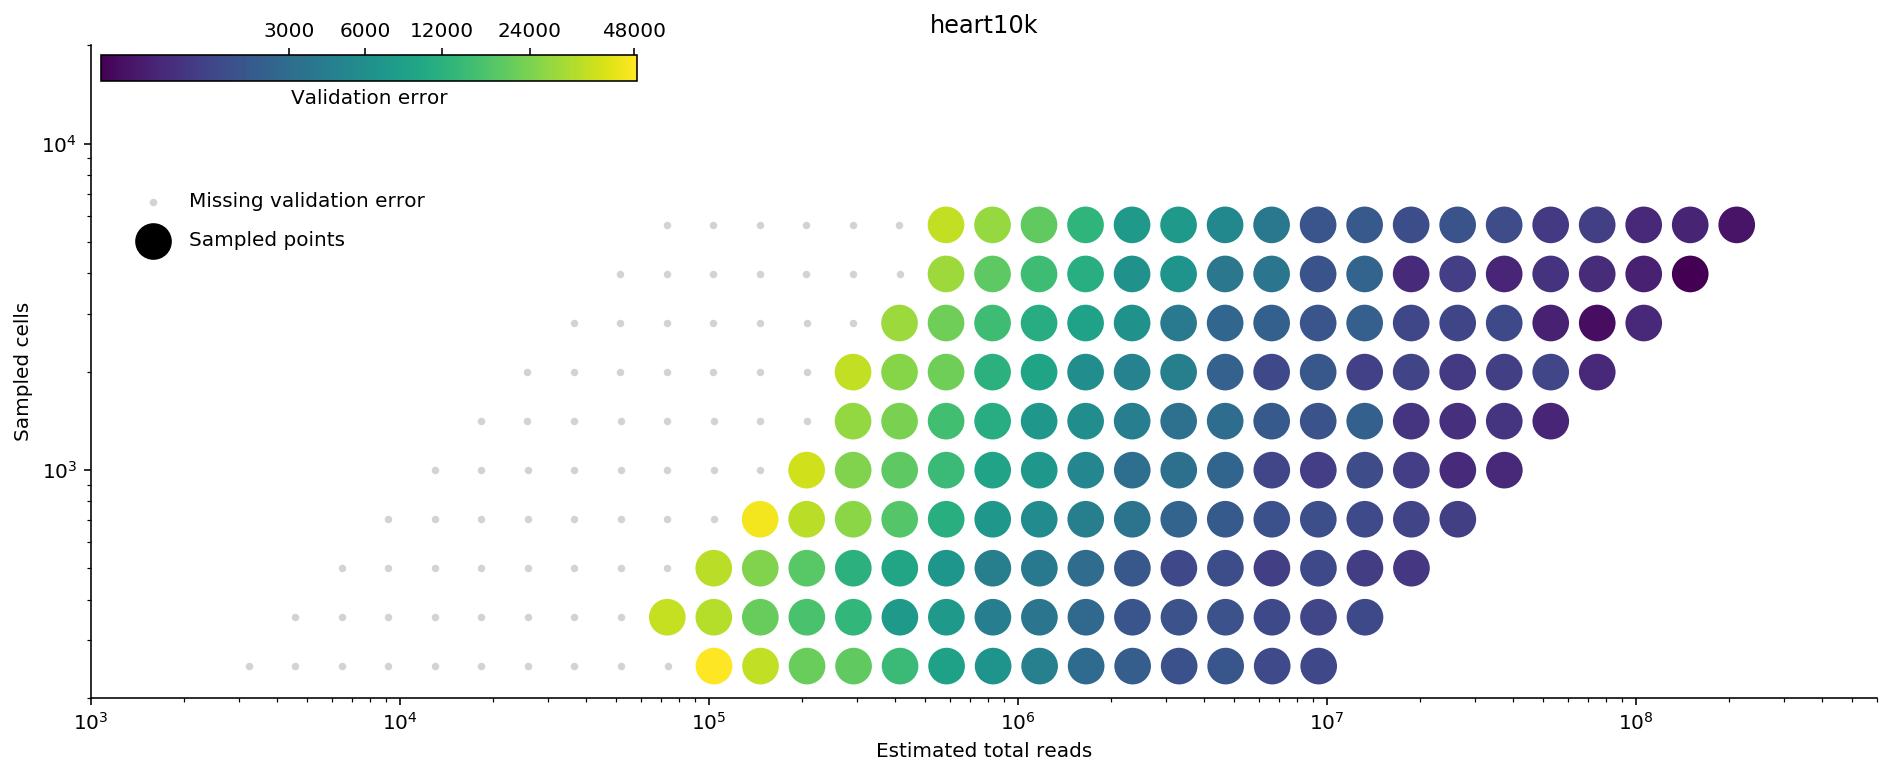

/home/munfred/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


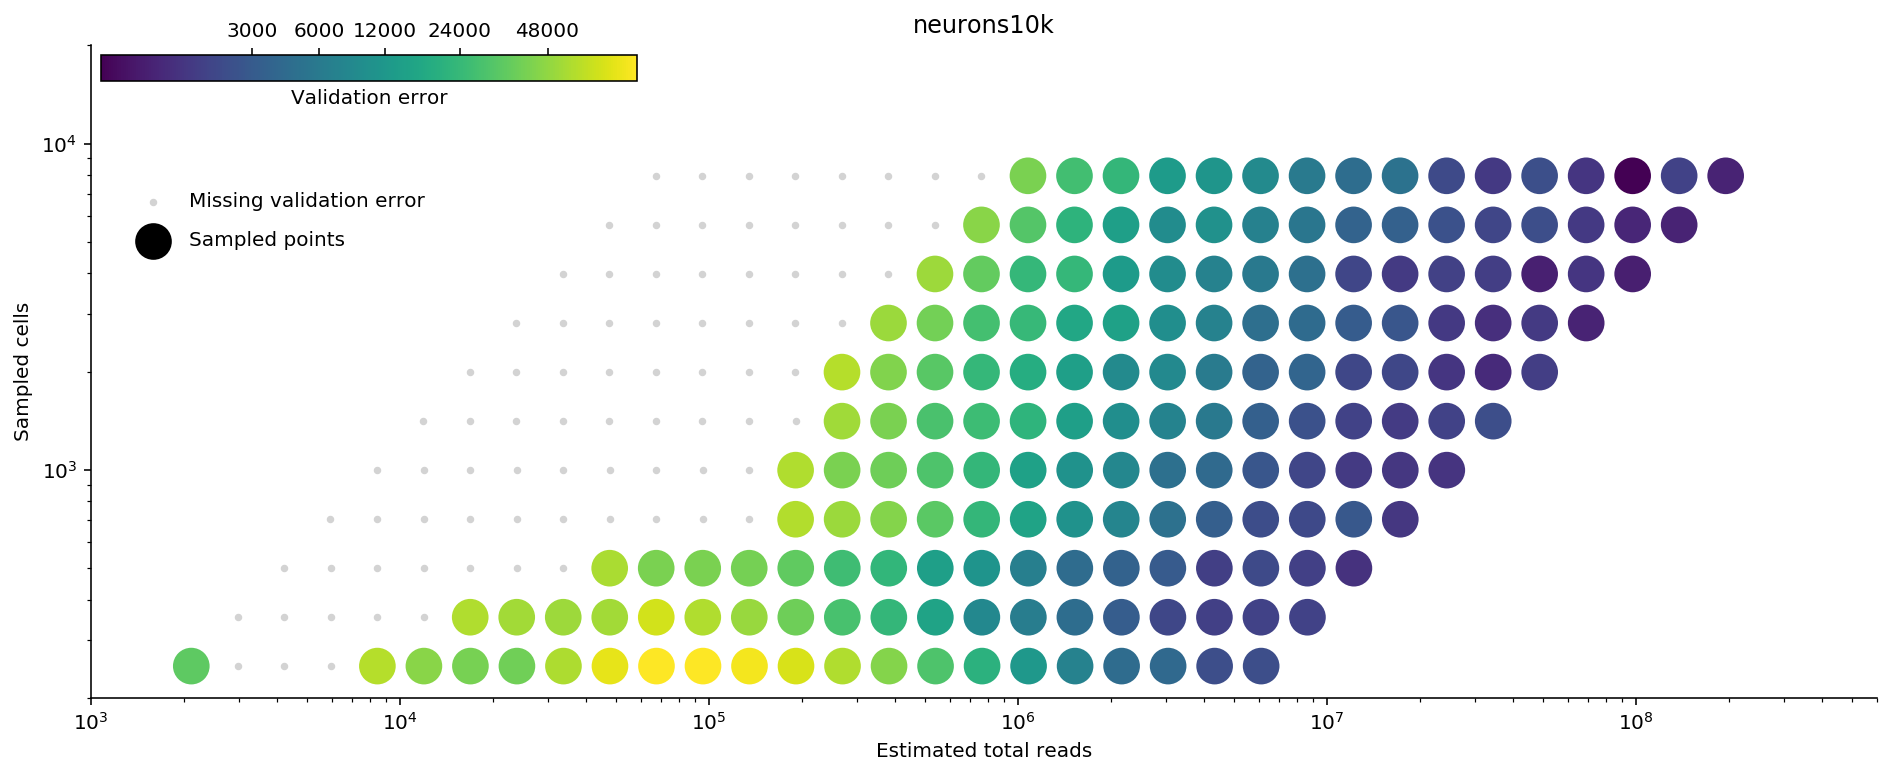

/home/munfred/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


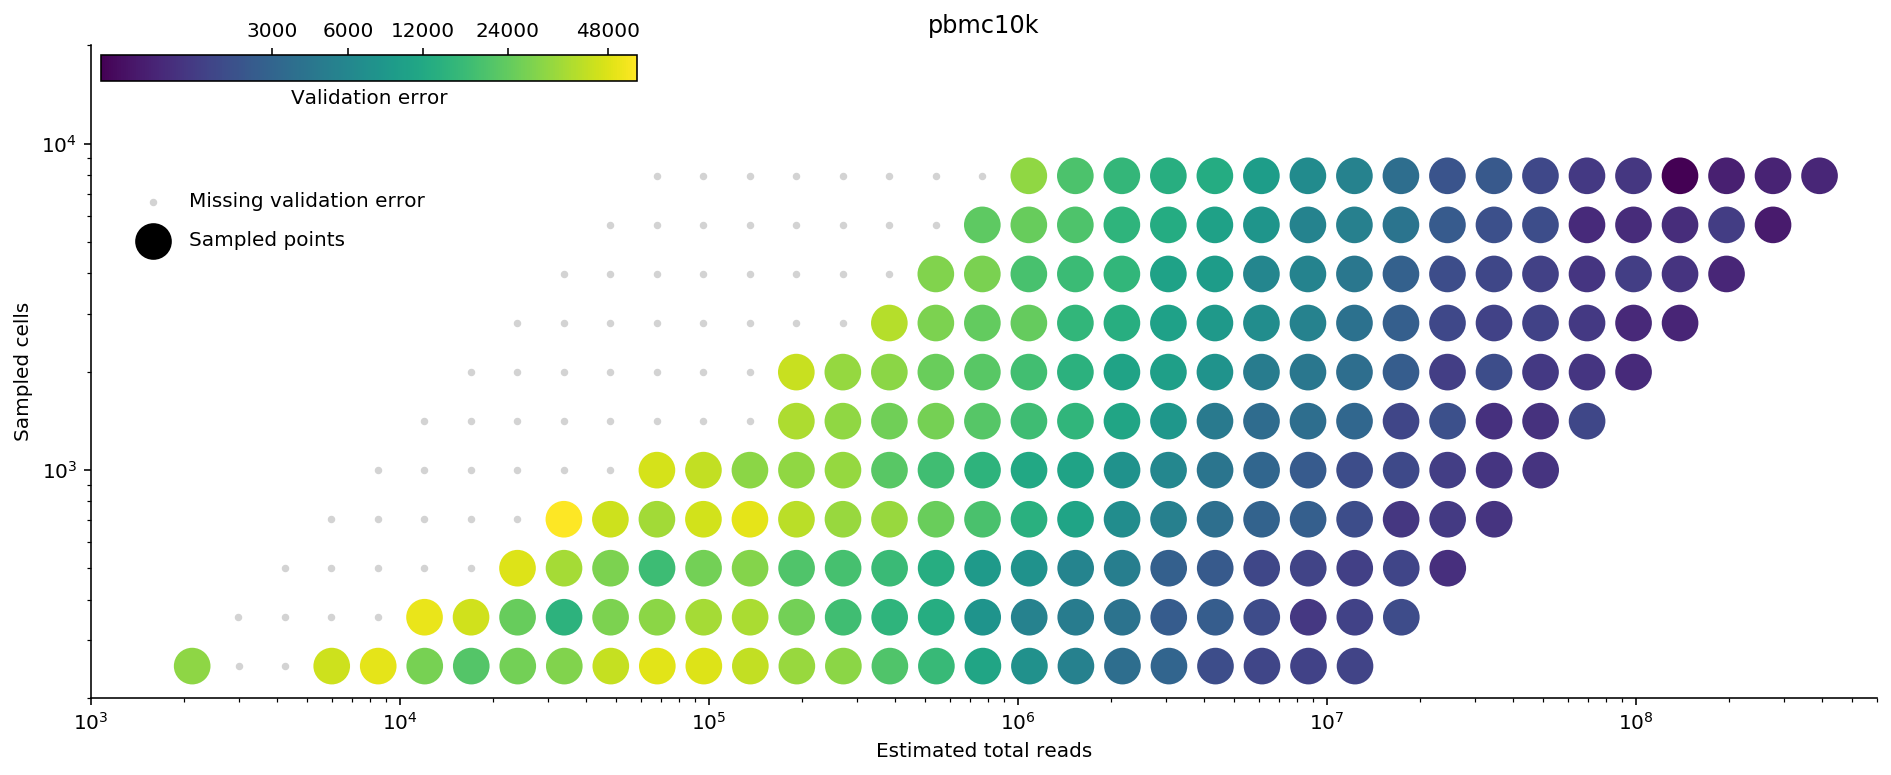

In [6]:
# make pseudo heatmap of validation error
for ds in ddf['ds']:
    # removes entries with all reads to keep spacing even
    total_reads_in_dataset=ddf.loc[ds]['total_reads_in_dataset']    
    nomaxreads_summary_results = summary_results[ds][summary_results[ds]['total_seqtk_reads']!=total_reads_in_dataset]        
    fig = plt.figure(figsize=(16, 6))
    # gs = gridspec.GridSpec(1, 2)

    plt.title(ds)

    plt.loglog()

    # ax0 = plt.subplot(gs[0, 0])
    # plt.scatter(x, y, s=20)

    # ax1 = plt.subplot(gs[0, 1])
    plt.loglog()

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.scatter(nomaxreads_summary_results['estimated_reads'], 
                nomaxreads_summary_results['sampled_cells'],
                c='lightgray',
                s=30, 
                marker ='.',
                label = 'Missing validation error',
                zorder=0
               ) 

    plt.ylim(bottom=2e2, top=2e4)
    plt.xlim(left=1e3, right = 6e8)
    ax1 = plt.gca()


    plt.ylabel('Sampled cells');
    plt.xlabel('Estimated total reads');

    total_reads_in_dataset=ddf.loc[ds]['total_reads_in_dataset']    

    norm = colors.PowerNorm(.3)
    plt.scatter(nomaxreads_summary_results['estimated_reads'], 
                nomaxreads_summary_results['sampled_cells'],
                c=nomaxreads_summary_results['validation_error'],
                s=300, 
                marker ='o',
                norm=norm,
                label=None
               )

    cbaxes = inset_axes(ax1, width="30%", height="4%", loc=2) 

    cb = plt.colorbar(
        cax=cbaxes,
        label='Validation error', 
        ticks=[3000, 6000, 12000, 24000, 48000], 
        orientation='horizontal',
    )

    cbaxes.xaxis.set_ticks_position('top')


    cb.solids.set_rasterized(True)

    plt.scatter(nomaxreads_summary_results['estimated_reads'], 
                nomaxreads_summary_results['sampled_cells'],
                c='lightgray',
                s=30, 
                marker ='.',
                label = 'Missing validation error',
                zorder=0
               ) 

    plt.scatter(100000,10000, c='k',
                s=300, 
                marker ='o',
                norm=norm,
                label='Sampled points')

    plt.legend(loc='upper left',
                labelspacing=1,
                borderpad=1.1,
                bbox_to_anchor=(0, -3),
              frameon=False)



    plt.savefig(figfolder+ 'main_pseudoheatmap_' + ds +'.pdf', dpi = 300, bbox_inches='tight')
    plt.show()

# Save a million tsnes in png

In [7]:
# For each sampled point for each dataset, create a tsne of teh sampled cells
# Then save each tsne in a png for plotting

for ds in ddf['ds']:
    print(ds, ': making', len(summary_results[ds]), 't-SNEs')
    summary_results[ds]['png_path']=np.nan

    for idx, row in tqdm(summary_results[ds].iterrows()):
        total_seqtk_reads = row['total_seqtk_reads']
        sampled_cells = row['sampled_cells']
        item = full_results[ds].query('total_seqtk_reads == @total_seqtk_reads and sampled_cells == @sampled_cells')
        fig, ax = plt.subplots()
        ax.scatter(item['tsne_0'], item['tsne_1'], c = 'k', alpha = 0.5, lw=0, s = 50)
        ax.axis('equal')
        ax.axis('off')
        tsnes_dir = os.path.join(figfolder, str(ds + '_tsnes/'))

        if not os.path.isdir(tsnes_dir): 
            os.makedirs(tsnes_dir)
    
        figpath = tsnes_dir + ds + '_tsne_' + str(sampled_cells) + '_cells_'+ str(total_seqtk_reads)+'_reads.png'
        summary_results[ds]['png_path'].loc[idx] = figpath
        plt.savefig(figpath, dpi = 100, transparent=True)
        plt.close()
print('Done!')


0it [00:00, ?it/s]

heart10k : making 250 t-SNEs


/home/munfred/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
250it [00:24, 11.74it/s]
1it [00:00,  5.20it/s]

neurons10k : making 275 t-SNEs


275it [00:26, 10.77it/s]
2it [00:00, 12.71it/s]

pbmc10k : making 297 t-SNEs


297it [00:27, 10.88it/s]

Done!


# Scatter t-SNE plot
This is figure 4

Processing...  heart10k


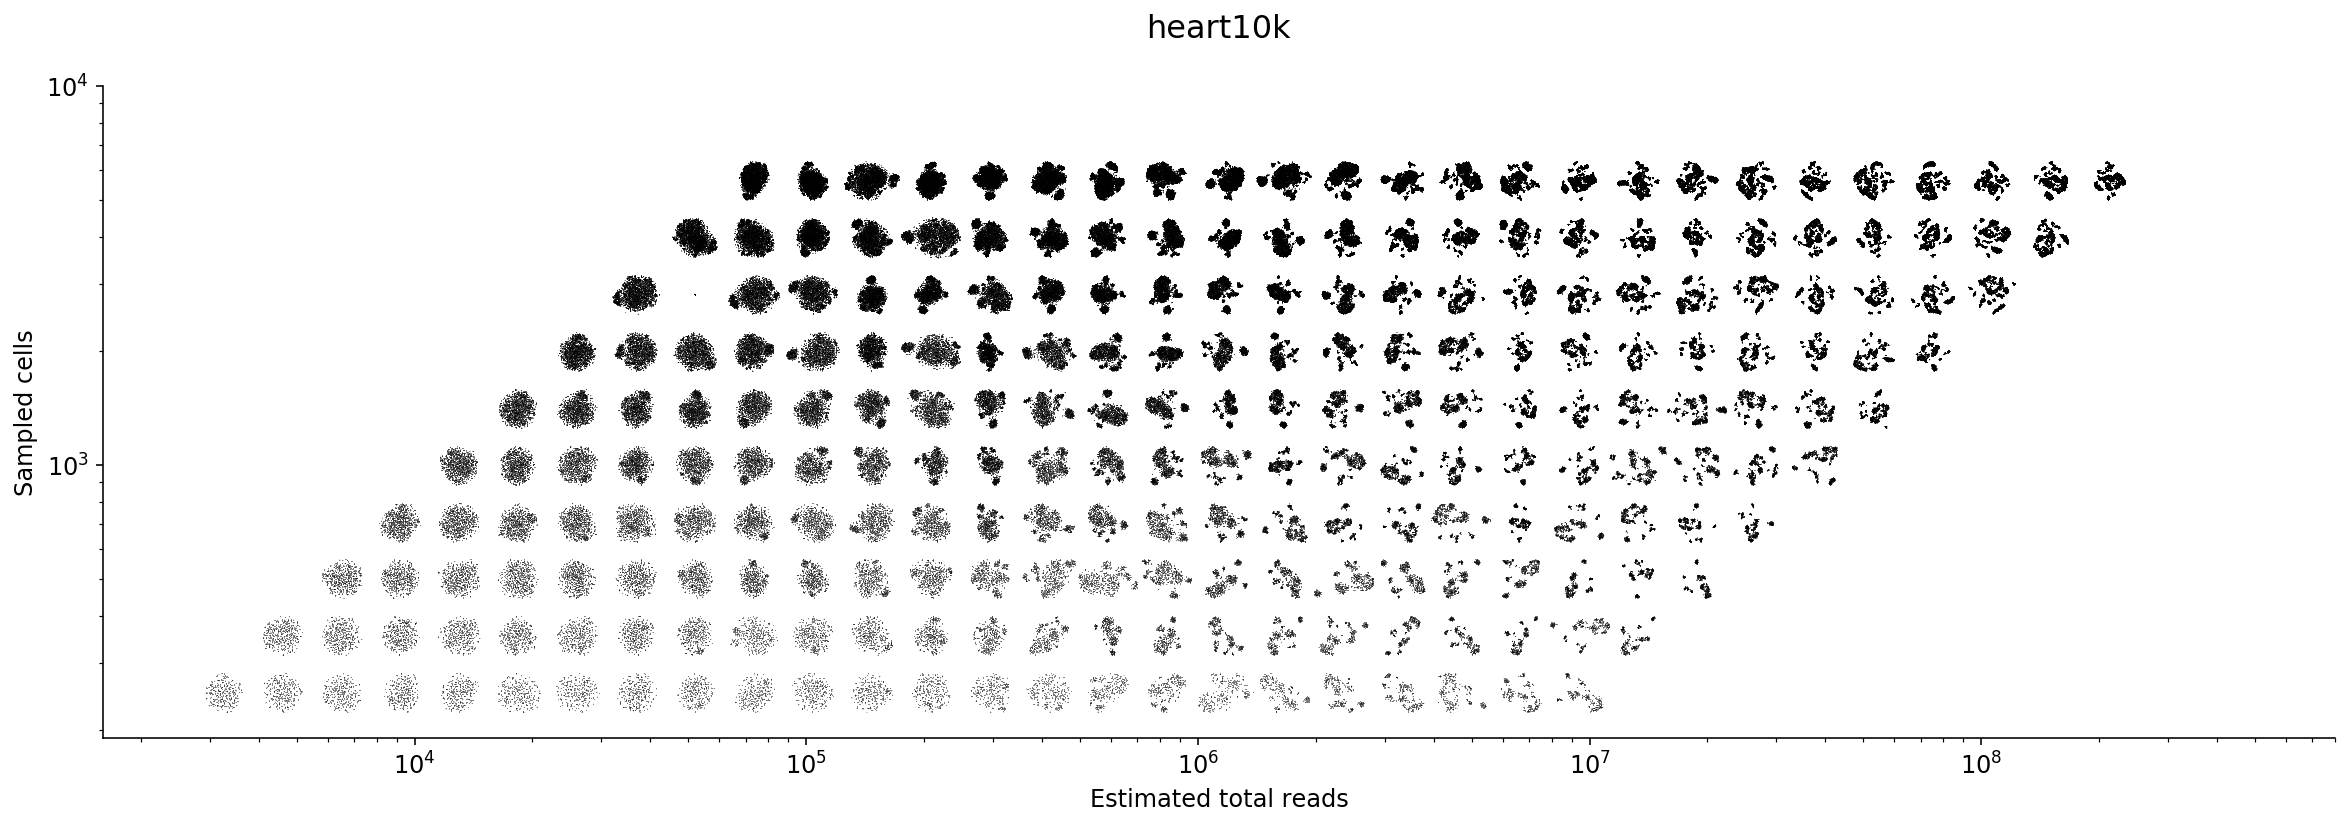

Processing...  neurons10k


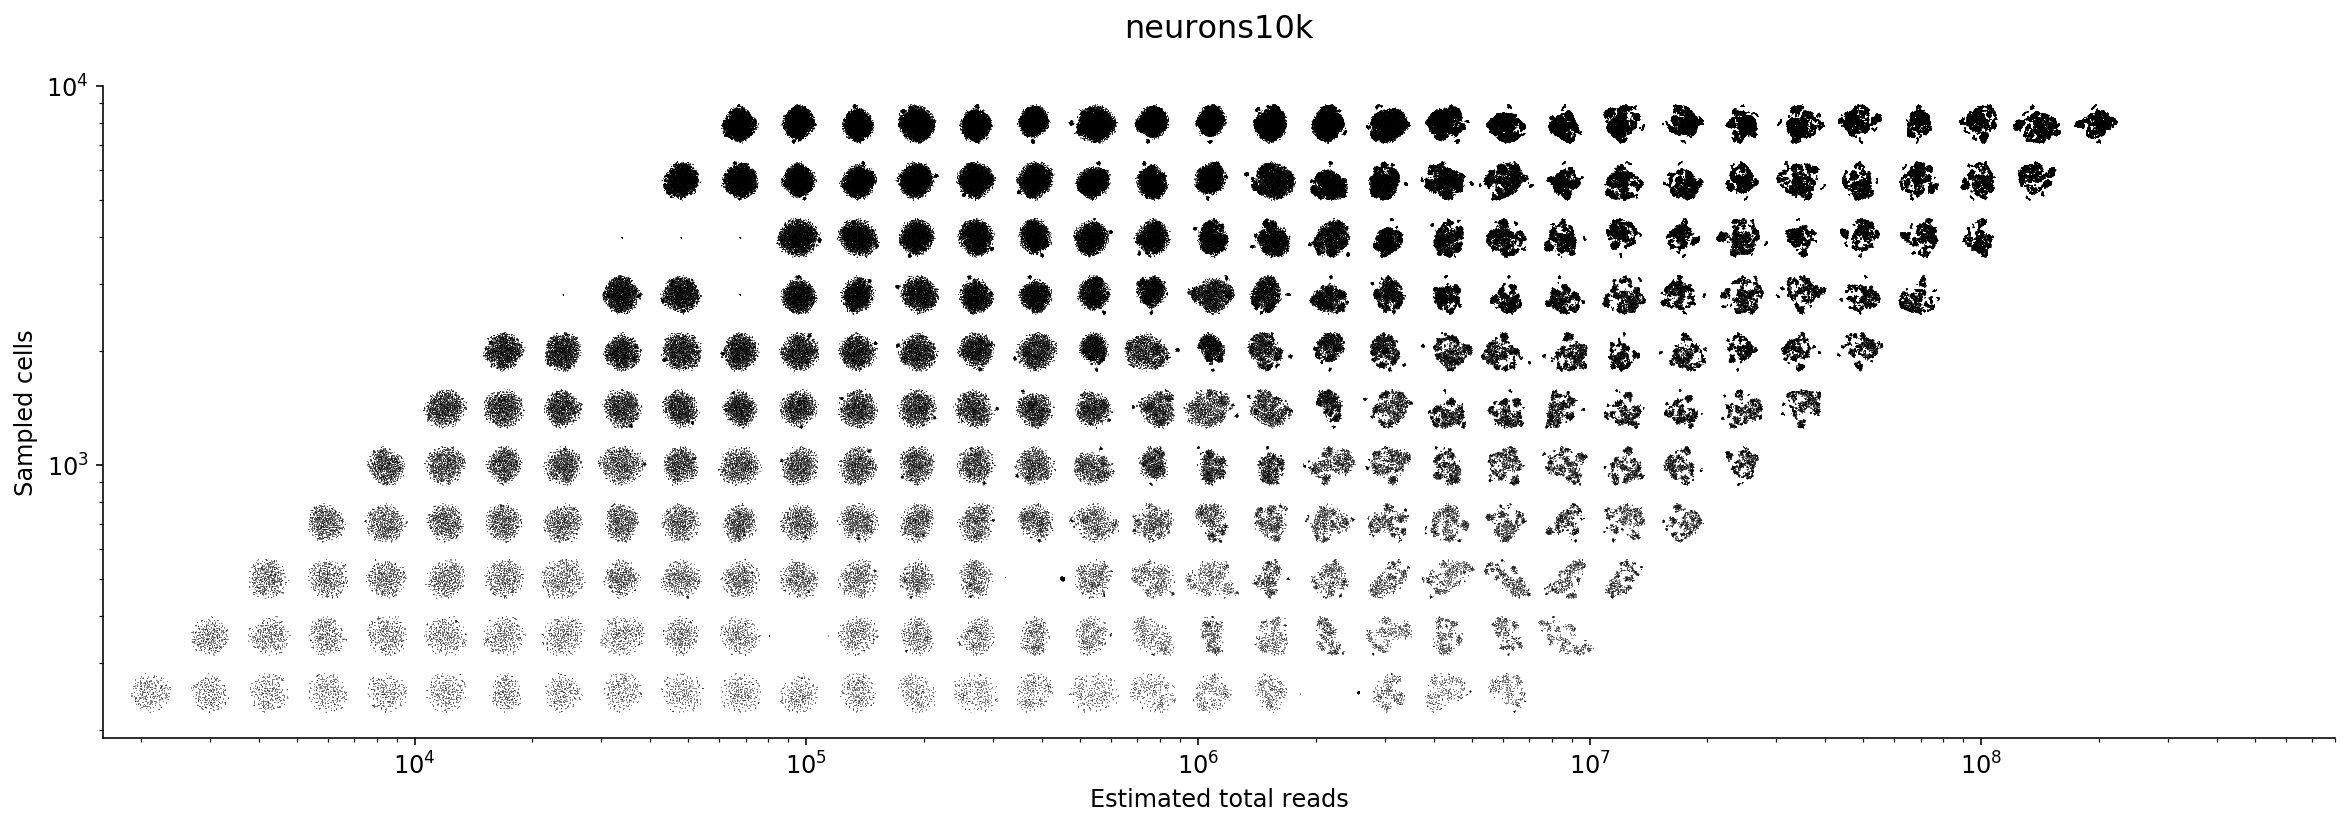

Processing...  pbmc10k


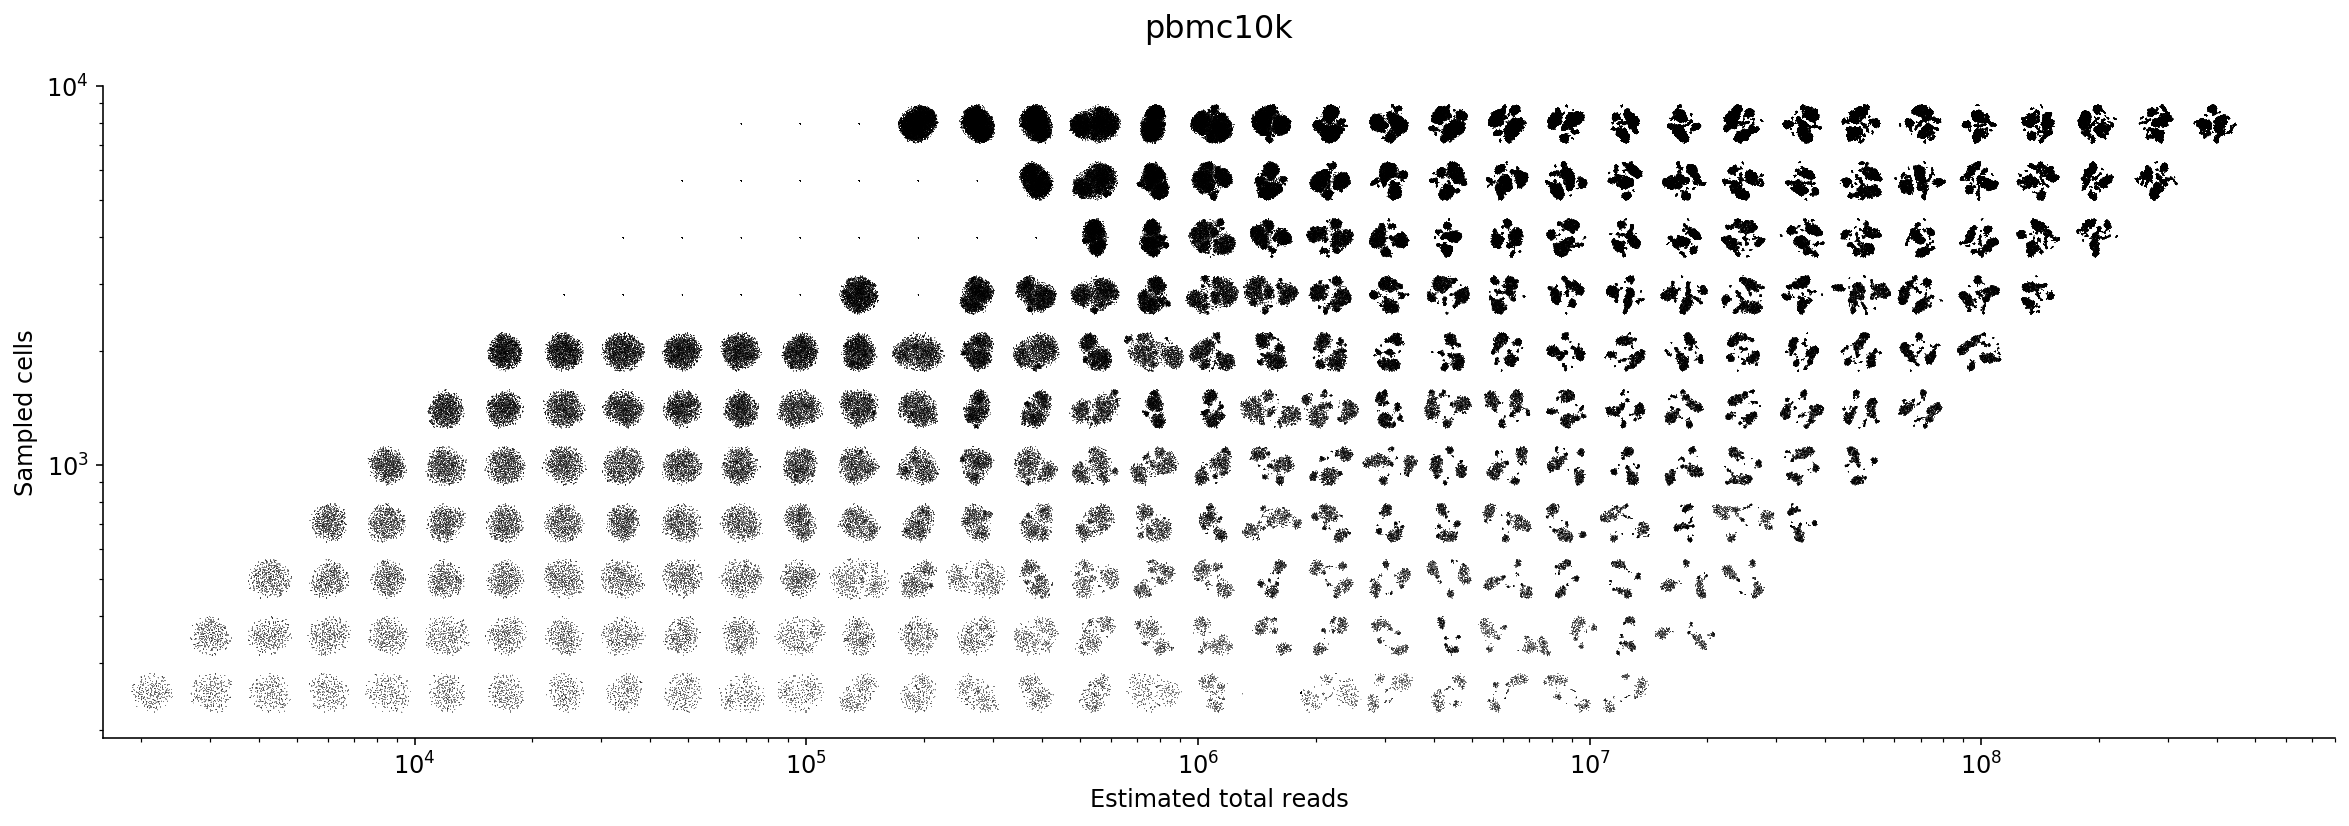

In [8]:
for ds in ddf['ds']:
    print('Processing... ', ds)
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.scatter(summary_results[ds]['reads_per_cell'], summary_results[ds]['sampled_cells'], s=0, c = 'k') 

    ax.set_xscale('log')
    ax.set_yscale('log')

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlim(1600, 8e8)
    ax.set_ylim(190, 10000)
#     ax.set_xlim(3000, summary_results[ds]['total_seqtk_reads'].max())
#     ax.set_ylim(400, summary_results[ds]['sampled_cells'].max())

    ax.set_xlabel('Estimated total reads', fontsize=12)
    ax.set_ylabel('Sampled cells', fontsize=12);
    title=ds + '\n'
    ax.set_title(title, fontsize=16)
    # ax.margins(0.07)
    for idx, row in summary_results[ds].iterrows():
        
        # skip plotting the tsne with all the theads because its not evenly spaced
        if row['total_seqtk_reads']==ddf.loc[ds]['total_reads_in_dataset']:
            continue
        ab = AnnotationBbox(OffsetImage(plt.imread(row['png_path']), zoom = 0.07), 
                            (row['estimated_reads'], row['sampled_cells']), 
                            frameon=False)
        
        ax.add_artist(ab)

#     plt.savefig(figfolder+ 'scatter-tsne_' + ds +'.pdf', dpi = 300)
# save in high res
    plt.savefig(figfolder+ 'main_scatter-tsne_' + ds +'_600dpi.pdf', dpi = 600)

    plt.show()


# Plot reads vs UMIs
This is supplementary figure 1

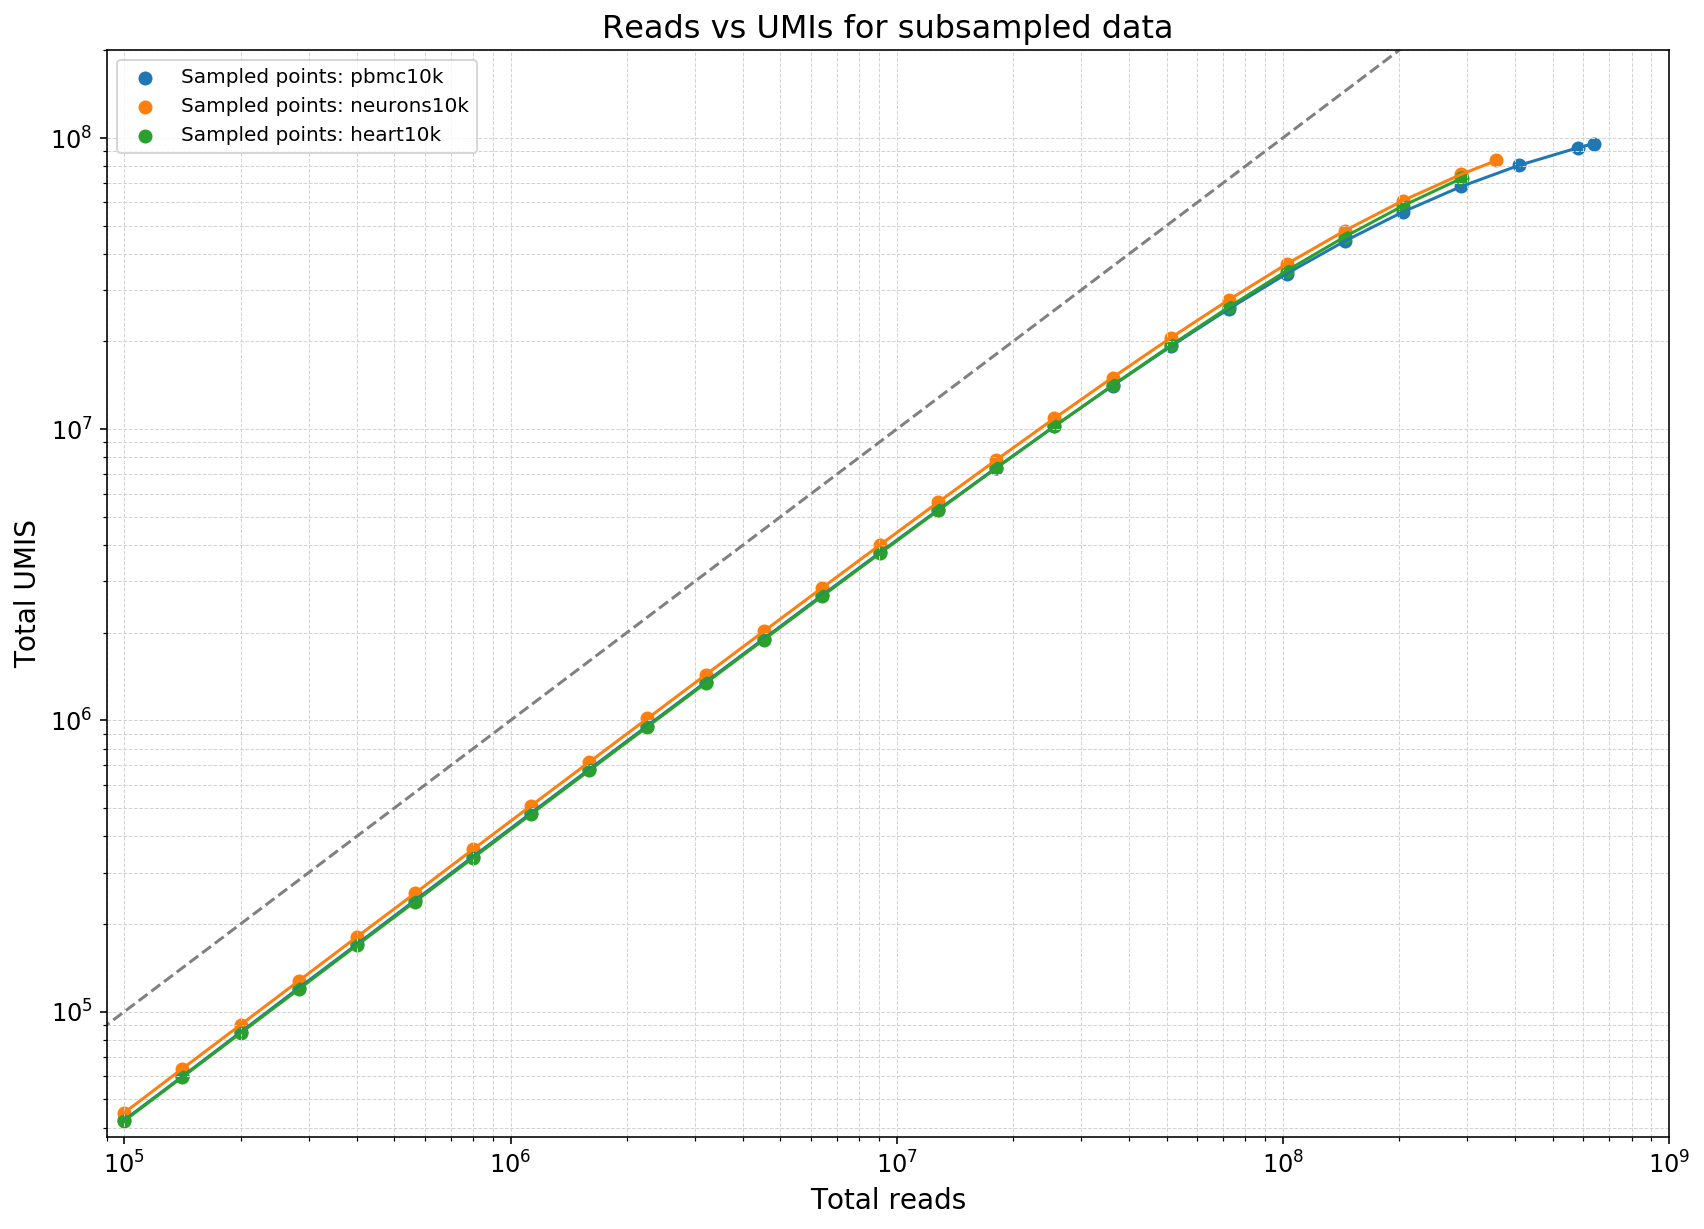

In [9]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'axes.titlesize': 16})

for ds in ['pbmc10k', 'neurons10k', 'heart10k']:
    reads_umis_df = summary_results[ds].drop_duplicates(subset=['total_seqtk_reads'])
    reads_umis_df = reads_umis_df.sort_values(by=['total_seqtk_reads'])
    reads_umis_df
    plt.plot(reads_umis_df['total_seqtk_reads'], 
             reads_umis_df['total_UMIs']
            )
    plt.scatter(reads_umis_df['total_seqtk_reads'], 
                reads_umis_df['total_UMIs'], 
                label='Sampled points: ' + ds, 
                )
plt.legend()
plt.plot( [0,1e9],[0,1e9], c = 'gray', ls = "--", label = 'Identity line')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.grid()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total reads')
plt.ylabel('Total UMIS');
title =  ds
plt.title('Reads vs UMIs for subsampled data')
plt.grid(True,which="both",ls="--", lw=0.5, c= 'lightgray')


plt.ylim(bottom=3.7e4, top=2e8)
plt.xlim(left=9e4, right = 1e9)
plt.savefig(figfolder + 'supp_total_reads_vs_umis.pdf', bbox_inches='tight')

# Plot composition of validation error vs sampled reads, UMIs and cells
These are supplementary figures 2-4

heart10k
Saved heart10k
neurons10k
Saved neurons10k
pbmc10k
Saved pbmc10k


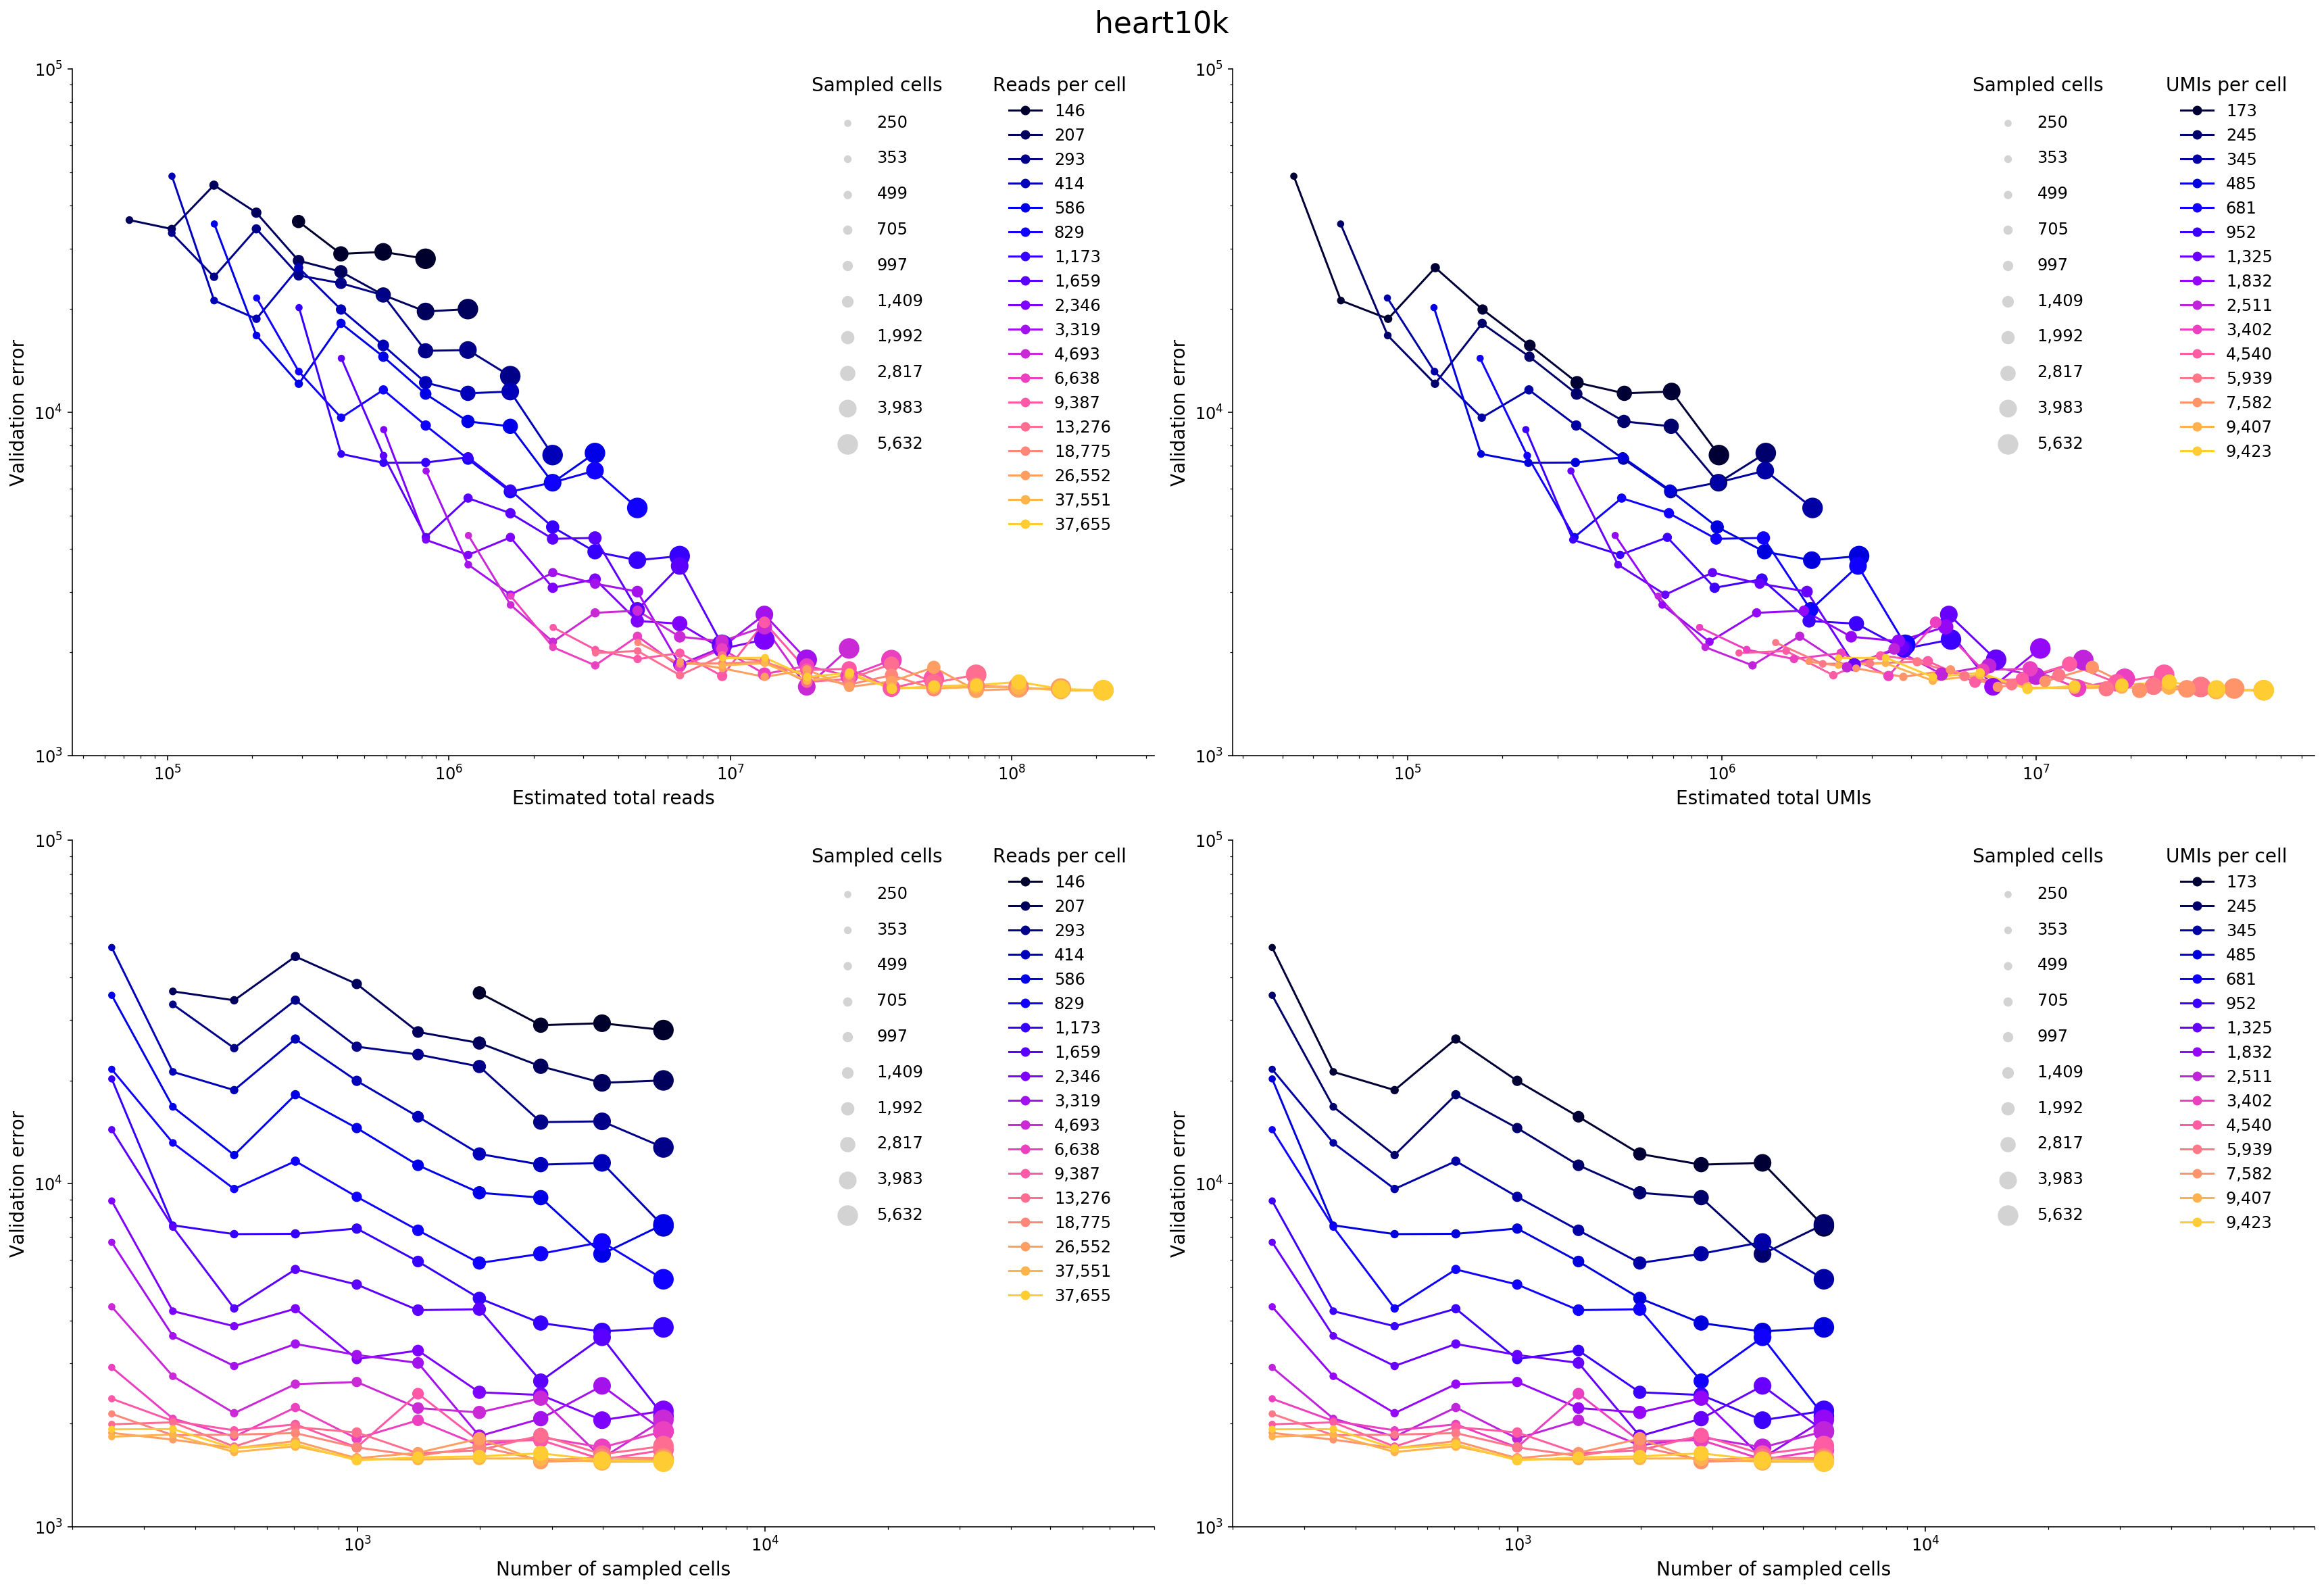

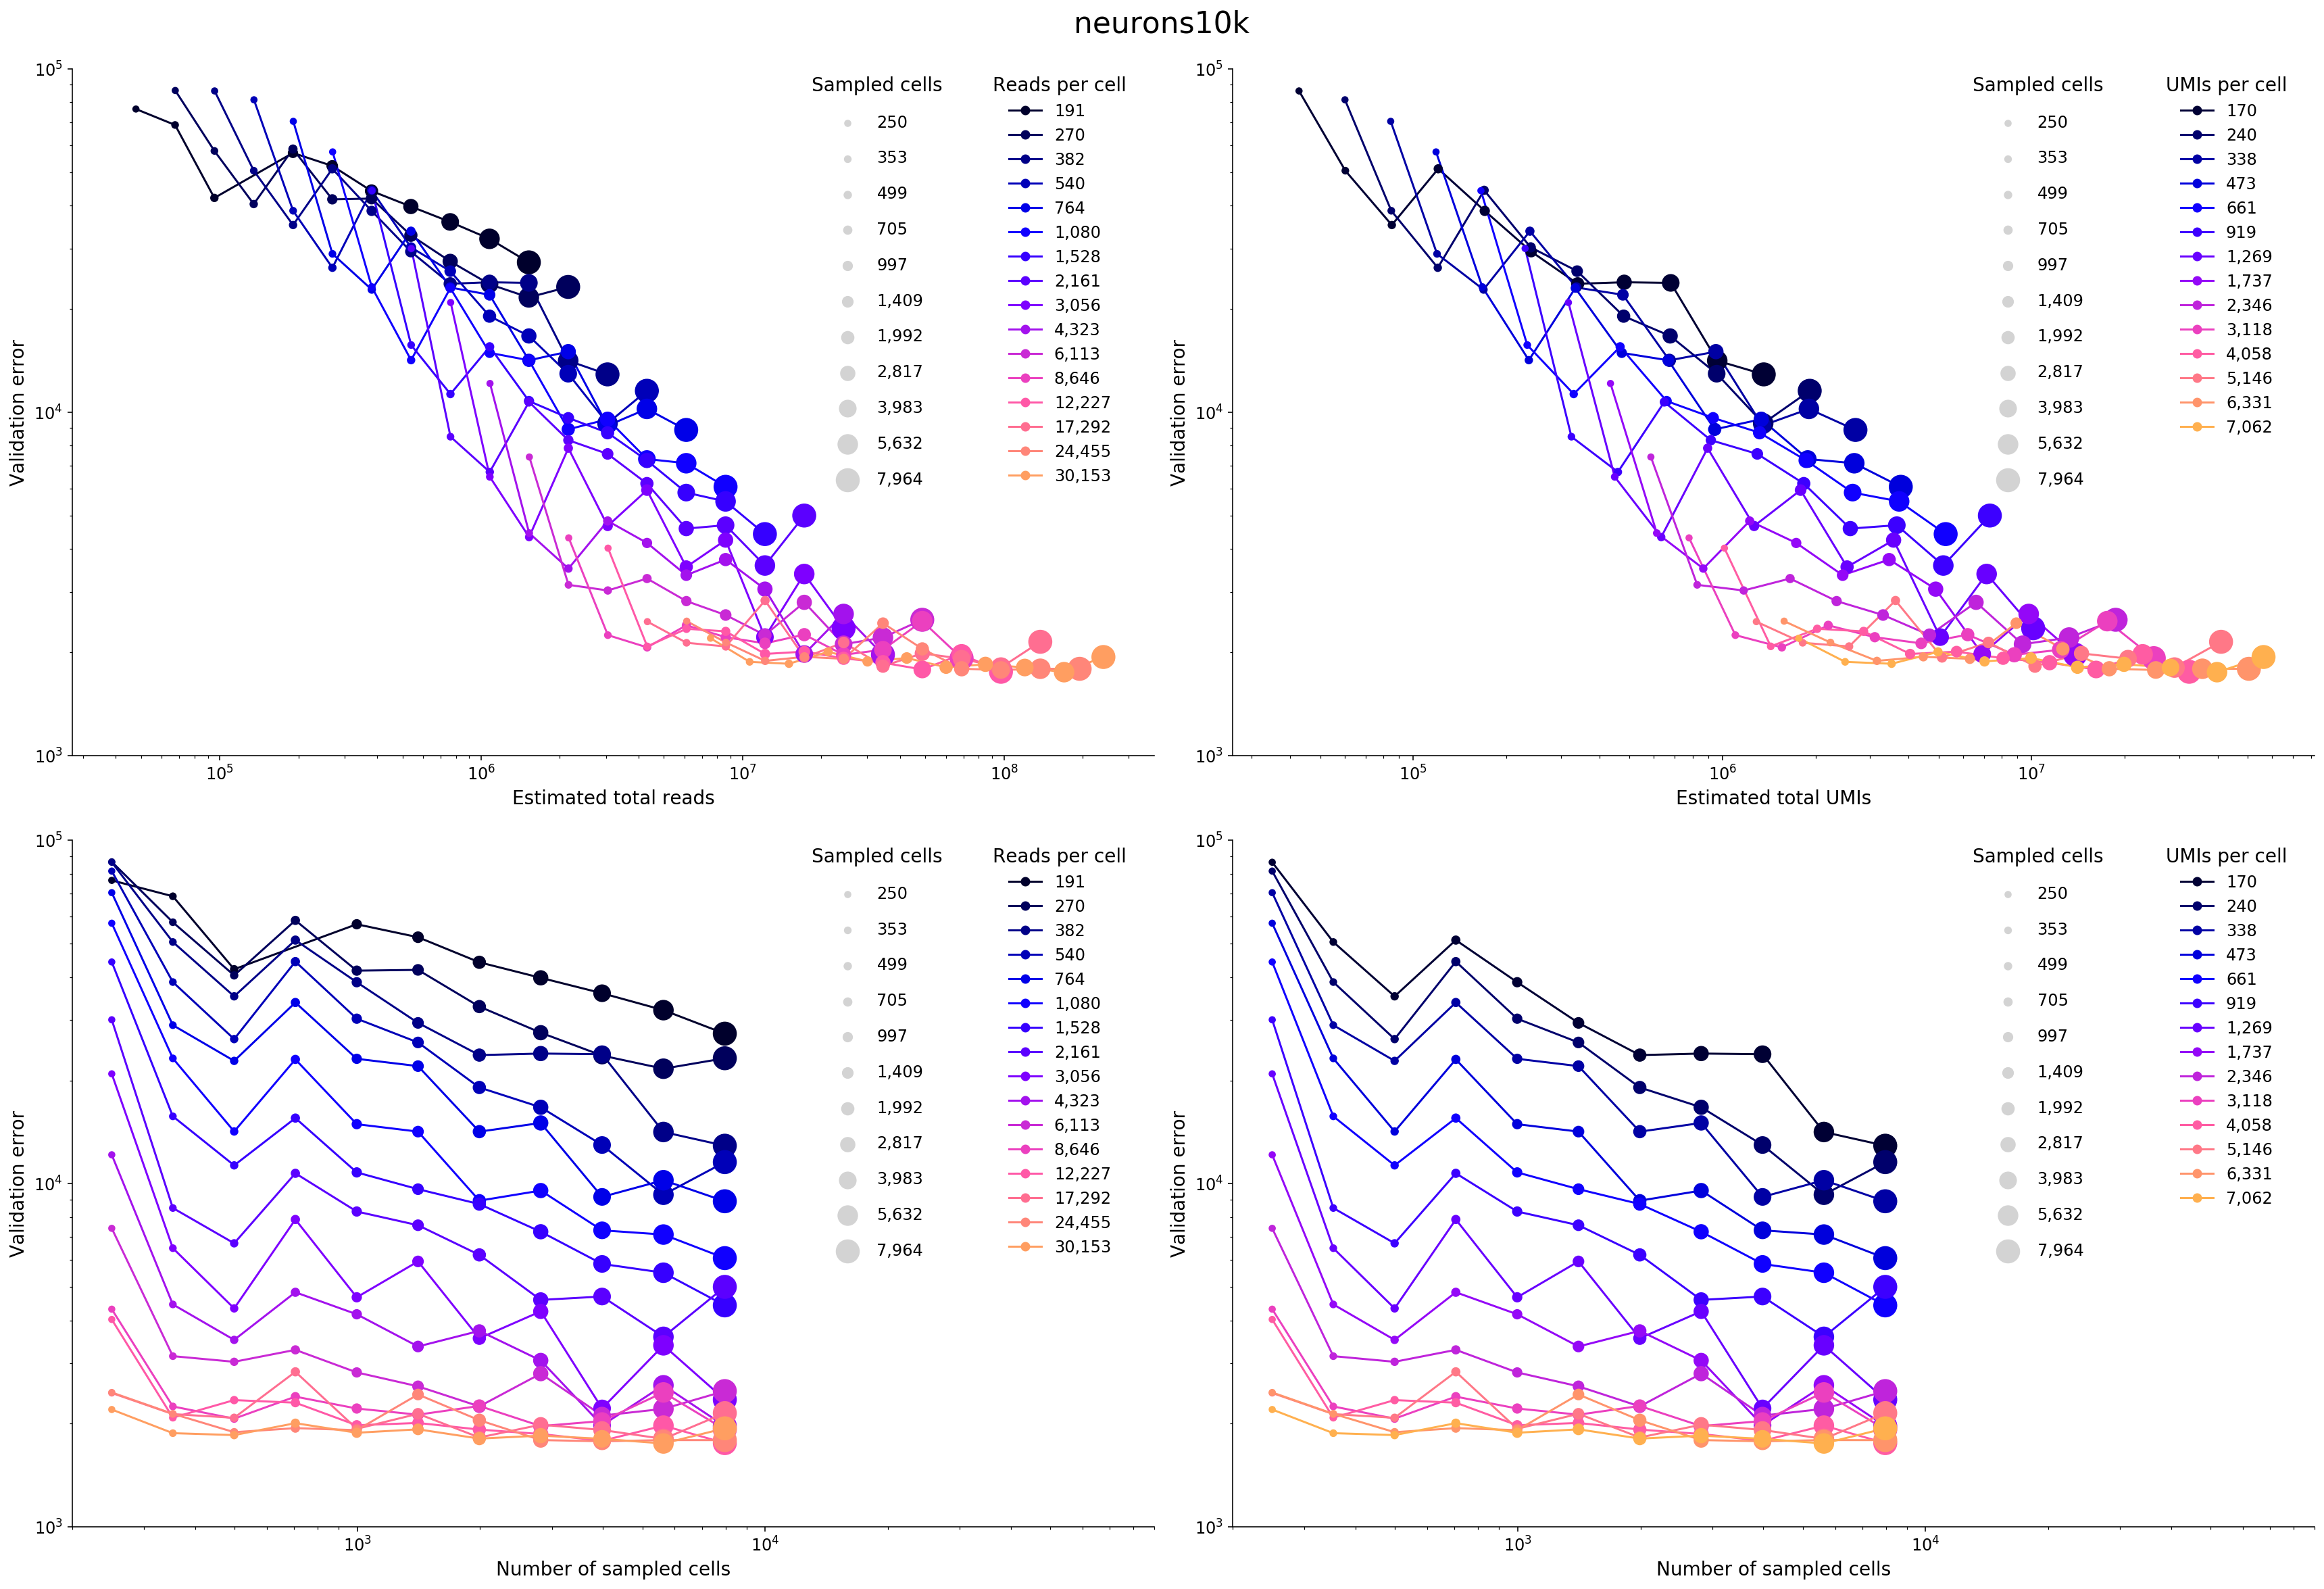

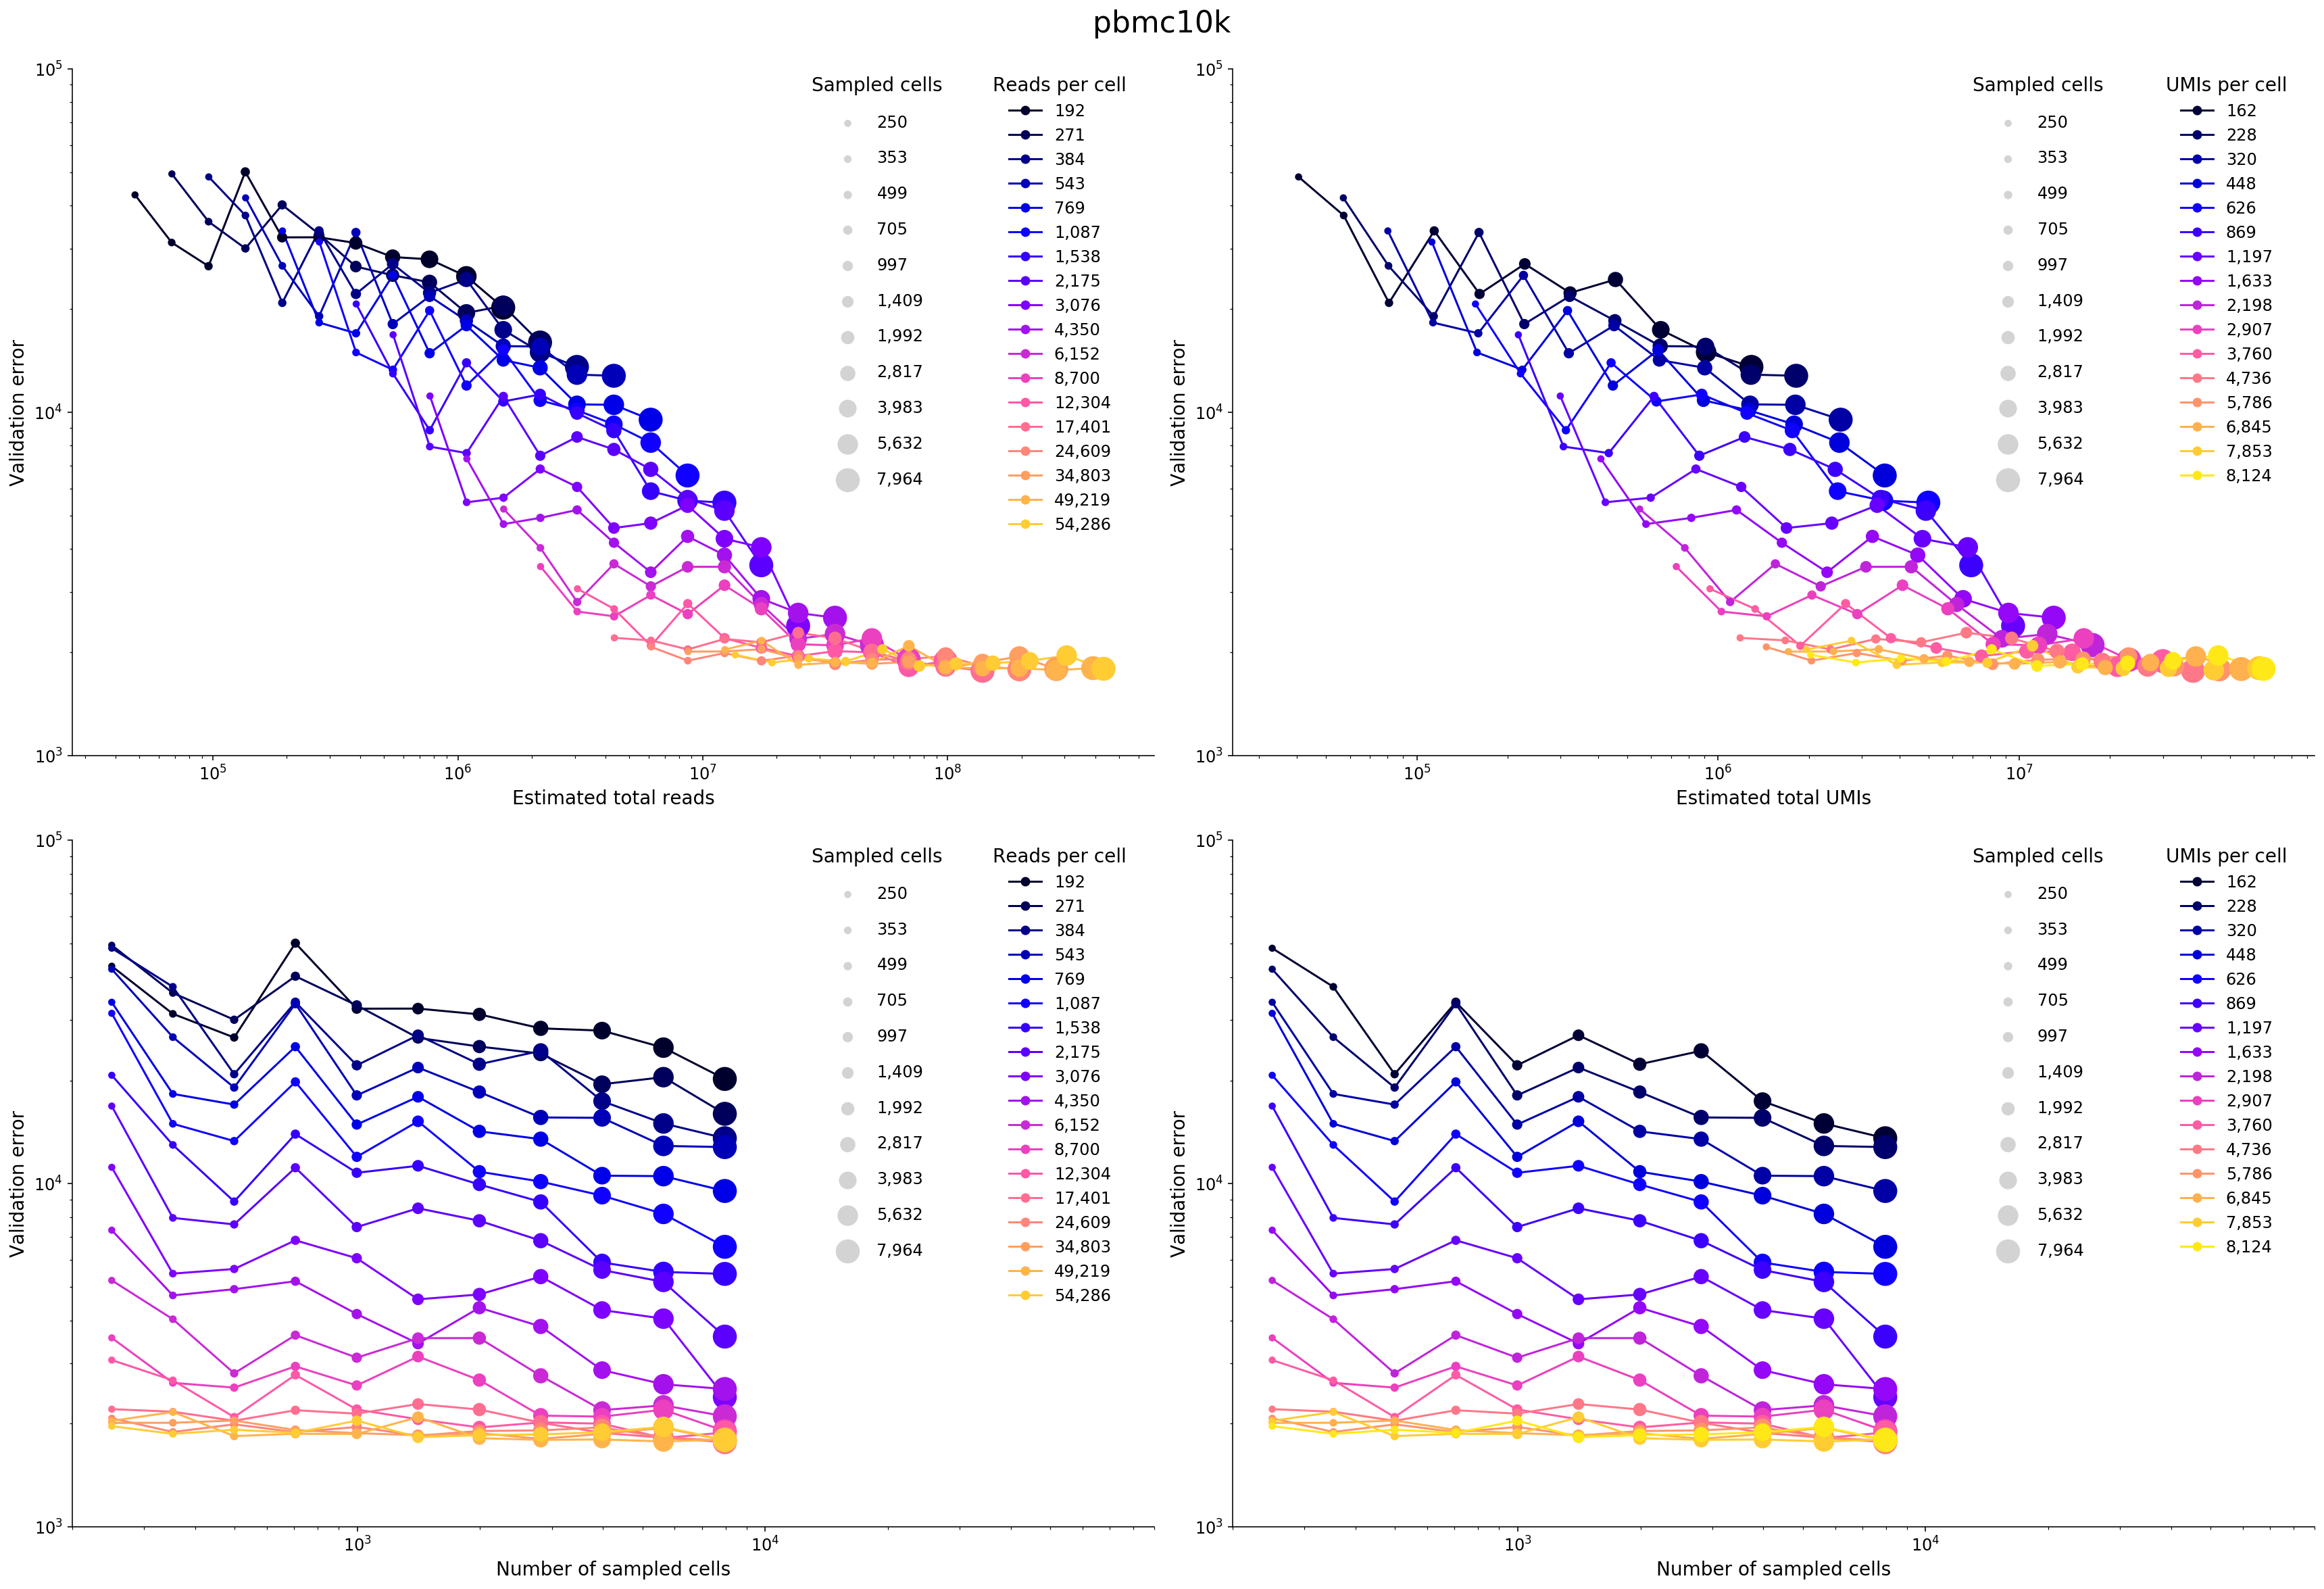

In [10]:
# for ds in ['heart10k']:
for ds in ddf['ds']:
    print(ds)
    fig = plt.figure(figsize=(24, 16))
    plt.subplot(221)
    plt.rcParams.update({'axes.labelsize': 14})
    plt.rcParams.update({'ytick.labelsize': 12})
    plt.rcParams.update({'xtick.labelsize': 12})
    plt.rcParams.update({'axes.titlesize': 16})
    
    #############################################################################################
    #
    #                  PART 1) PLOT TOTAL READS VS VALIDATION
    #
    ############################################################################################

    depths_handles = []
    cells_handles = []

    c_offset = 0
    b_offset = 4
    i = 0
    for d_, grp_ in summary_results[ds].groupby('reads_per_cell'):
        if d_ <= 144:
            continue

        i += 1
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  # ITS HERE
        grp_ = grp_.sort_values('estimated_reads').dropna()
        handle = plt.plot(grp_['estimated_reads'], 
                          grp_['validation_error'], 
                          zorder=3, 
                          marker='.', 
                          label=f'{d_:0,.0f}', 
                          color=c_
                         )[0]
        chandle=plt.scatter(grp_['estimated_reads'], 
                            grp_['validation_error'], 
                            zorder=4, 
                            marker='o', 
                            s= 10 + (grp_['sampled_cells']/total_cells)*400, 
                            c=[c_]
                           )
        depths_handles.append(handle)
#         plt.annotate(f'{d_:1,.0f}', 
#                      xy    =(grp_.iloc[0]['estimated_reads'] *0.98      , grp_.iloc[0]['validation_error']), 
#                      xytext=(grp_.iloc[0]['estimated_reads']*0.80, grp_.iloc[0]['validation_error']*0.85),
#                     ha='right', fontsize=12 , color=c_, 
#                      arrowprops=dict(
#                          facecolor=c_, 
#                          edgecolor=c_, 
#                          arrowstyle="->", 
#                          connectionstyle="arc3,rad=-0.2"))

    first_legend = plt.legend(
        handles=depths_handles,
        loc=1,
        title='Reads per cell',
        bbox_to_anchor=(1, 1.03),
        markerscale=2,
        fontsize=12,
        title_fontsize=14,
        borderpad=1.2,
        frameon=False
    )

    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for n_ in grp_['sampled_cells']:
        chandle=plt.scatter(1, 1, zorder=4, marker='o', 
                            label=f'{n_:0,.0f}',
                            s= 10 + (n_/total_cells)*400, c='lightgray')
        cells_handles.append(chandle)


    second_legend = plt.legend(
        handles=cells_handles,
        loc='upper right',
        bbox_to_anchor=(0.83, 1.03),
        title='Sampled cells',
        labelspacing=1.2,
        borderpad=1.2,
        fontsize=12,
        title_fontsize=14,
        frameon=False
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Estimated total reads')
    plt.ylabel('Validation error');
#     title =  ds
#     plt.title(title)

    plt.ylim(bottom=1e3, top=1e5)
#     plt.xlim(left=7e4, right = 1e9)
    
    #############################################################################################
    #
    #                  PART 2) PLOT TOTAL UMIS VS VALIDATION
    #
    ############################################################################################
    
    plt.subplot(222)
    plt.rcParams.update({'axes.labelsize': 14})
    plt.rcParams.update({'ytick.labelsize': 12})
    plt.rcParams.update({'xtick.labelsize': 12})
    plt.rcParams.update({'axes.titlesize': 16})

    depths_handles = []
    cells_handles = []

    c_offset = 0
    b_offset = 4
    i = 0
    for d_, grp_ in summary_results[ds].groupby('UMIs_per_cell'):
        if d_ <= 144:
            continue

        i += 1.2
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  # ITS HERE
        grp_ = grp_.sort_values('estimated_UMIs').dropna()
        handle = plt.plot(grp_['estimated_UMIs'], 
                          grp_['validation_error'], 
                          zorder=3, 
                          marker='.', 
                          label=f'{d_:0,.0f}', 
                          color=c_
                         )[0]
        chandle=plt.scatter(grp_['estimated_UMIs'], 
                            grp_['validation_error'], 
                            zorder=4, 
                            marker='o', 
                            s= 10 + (grp_['sampled_cells']/total_cells)*400, 
                            c=[c_]
                           )
        depths_handles.append(handle)
#         plt.annotate(f'{d_:1,.0f}', 
#                      xy    =(grp_.iloc[0]['estimated_UMIs'] *0.98      , grp_.iloc[0]['validation_error']), 
#                      xytext=(grp_.iloc[0]['estimated_UMIs']*0.80, grp_.iloc[0]['validation_error']*0.85),
#                     ha='right', fontsize=12 , color=c_, 
#                      arrowprops=dict(
#                          facecolor=c_, 
#                          edgecolor=c_, 
#                          arrowstyle="->", 
#                          connectionstyle="arc3,rad=-0.2"))

    first_legend = plt.legend(
        handles=depths_handles,
        loc=1,
        title='UMIs per cell',
        bbox_to_anchor=(1, 1.03),
        markerscale=2,
        fontsize=12,
        title_fontsize=14,
        borderpad=1.2,
        frameon=False
    )

    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for n_ in grp_['sampled_cells']:
        chandle=plt.scatter(1, 1, zorder=4, marker='o', 
                            label=f'{n_:0,.0f}',
                            s= 10 + (n_/total_cells)*400, c='lightgray')
        cells_handles.append(chandle)


    second_legend = plt.legend(
        handles=cells_handles,
        loc='upper right',
        bbox_to_anchor=(0.83, 1.03),
        title='Sampled cells',
        labelspacing=1.2,
        borderpad=1.2,
        fontsize=12,
        title_fontsize=14,
        frameon=False
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Estimated total UMIs')
    plt.ylabel('Validation error');
#     title =  ds
#     plt.title(title)

    plt.ylim(bottom=1e3, top=1e5)
#     plt.xlim(left=1e4, right = 1e9)
    
    #############################################################################################
    #
    #                  PART 3) PLOT SAMPLED CELLS VS VALIDATION WITH READS PER CELL
    #
    ############################################################################################    
    
    
    
    handles=[]
    plt.subplot(223)

    i = 0
    for d_, grp_ in summary_results[ds].groupby('reads_per_cell'):
        if d_ <= 144:
            continue

        i += 1
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  # ITS HERE
        grp_ = grp_.sort_values('estimated_reads').dropna()
        handle = plt.plot(grp_['sampled_cells'], grp_['validation_error'], 
                          zorder=3, marker='.', 
                          label=f'{d_:0,.0f}',
#                           label=int(d_), 
                          c= c_
                         )[0]
        chandle = plt.scatter(grp_['sampled_cells'], grp_['validation_error'], 
                              zorder=4, 
                              marker='o', 
                              s=10 + (grp_['sampled_cells'] / total_cells) * 400,
                              c=[c_]
        )

        handles.append(handle)
    first_legend = plt.legend(
        handles=handles,
        loc=1,
        title='Reads per cell',
        markerscale=2,
        fontsize=12,
        title_fontsize=14,
        bbox_to_anchor=(1, 1.03),
        borderpad=1.2,
        frameon=False
    )
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    cells_handles = []
    for n_ in grp_['sampled_cells']:
        chandle=plt.scatter(1, 1, zorder=4, marker='o', 
                            label=f'{n_:0,.0f}',
                            s= 10 + (n_/total_cells)*400, c='lightgray')
        cells_handles.append(chandle)


    second_legend = plt.legend(
        handles=cells_handles,
        loc='upper right',
        bbox_to_anchor=(0.83, 1.03),
        title='Sampled cells',
        labelspacing=1.2,
        borderpad=1.2,
        fontsize=12,
        title_fontsize=14,
        frameon=False
    )
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of sampled cells')
    plt.ylabel('Validation error');
    plt.ylim(bottom=1e3, top=1e5)
    plt.xlim(left=2e2, right=9e4)

    plt.subplots_adjust(wspace=0, hspace=0)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    
    
    #############################################################################################
    #
    #                  PART 4) PLOT SAMPLED CELLS VS VALIDATION WITH UMIS PER CELL
    #
    ############################################################################################
    
    plt.subplot(224)
    handles=[]
    i = 0
    for d_, grp_ in summary_results[ds].groupby('UMIs_per_cell'):
        if d_ <= 144:
            continue

        i += 1.2
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  # ITS HERE
        grp_ = grp_.sort_values('estimated_UMIs').dropna()
        handle = plt.plot(grp_['sampled_cells'], grp_['validation_error'], 
                          zorder=3, marker='.', 
                          label=f'{d_:0,.0f}',
#                           label=int(d_), 
                          c= c_
                         )[0]
        chandle = plt.scatter(grp_['sampled_cells'], grp_['validation_error'], 
                              zorder=4, 
                              marker='o', 
                              s=10 + (grp_['sampled_cells'] / total_cells) * 400,
                              c=[c_]
        )

        handles.append(handle)
    first_legend = plt.legend(
        handles=handles,
        loc=1,
        title='UMIs per cell',
        markerscale=2,
        fontsize=12,
        title_fontsize=14,
        bbox_to_anchor=(1, 1.03),
        borderpad=1.2,
        frameon=False
    )
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    cells_handles = []
    for n_ in grp_['sampled_cells']:
        chandle=plt.scatter(1, 1, zorder=4, marker='o', 
                            label=f'{n_:0,.0f}',
                            s= 10 + (n_/total_cells)*400, c='lightgray')
        cells_handles.append(chandle)


    second_legend = plt.legend(
        handles=cells_handles,
        loc='upper right',
        bbox_to_anchor=(0.83, 1.03),
        title='Sampled cells',
        labelspacing=1.2,
        borderpad=1.2,
        fontsize=12,
        title_fontsize=14,
        frameon=False
    )
    
    
    # plt.legend(scatterpoints=3, title='Reads per cell')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of sampled cells')
    plt.ylabel('Validation error');
#     title = ds
#     plt.title(title)
    plt.ylim(bottom=1e3, top=1e5)
    plt.xlim(left=2e2, right=9e4)

    plt.subplots_adjust(wspace=0, hspace=0)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()

    fig.suptitle(ds, fontsize=22, y = 1.02)

    plt.savefig(figfolder + 'supp_validation_error_composition_' + ds + '.pdf', bbox_inches='tight')
    print('Saved', ds)


# Make two linear models above and below reads per cell threshold

In [11]:
summary_results[ds].head()

total_seqtk_reads  sampled_cells  validation_error  UMIs  total_UMIs  \
pbmc10k                                                                         
0                  3200000            499           30040.3     0   1353775.0   
1                  3200000           2817           23938.9     0   1353775.0   
2                579261875            353            2164.1     0  92430124.0   
3                144815469           1409            2060.8     0  44258659.0   
4                  9050967            250           33783.1     0   3773430.0   

         estimated_reads  reads_per_cell  estimated_UMIs  UMIs_per_cell  \
pbmc10k                                                                   
0                 135678             271           57399            115   
1                 765944             271          324036            115   
2               17374410           49219         2772353           7853   
3               17337496           12304         5298704           3760   
4                 192262             769           80156            320   

                                                  png_path  
pbmc10k                                                     
0        ./figures/pbmc10k_tsnes/pbmc10k_tsne_499.0_cel...  
1        ./figures/pbmc10k_tsnes/pbmc10k_tsne_2817.0_ce...  
2        ./figures/pbmc10k_tsnes/pbmc10k_tsne_353.0_cel...  
3        ./figures/pbmc10k_tsnes/pbmc10k_tsne_1409.0_ce...  
4        ./figures/pbmc10k_tsnes/pbmc10k_tsne_250.0_cel...

# Make a model using the threshold with UMIs instead of reads to check there is little difference

In [12]:
threshold = 5000
mod_below = {}
res_below = {}
mod_above = {}
res_above = {}
statsmodels_summary = pd.DataFrame()
for ds in datasets:
    mod_below[ds] = {}
    res_below[ds] = {}
    mod_above[ds] = {}
    res_above[ds] = {}
    
    mod_below[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(UMIs_per_cell)', 
                                      data=summary_results[ds].query('UMIs_per_cell < @threshold').dropna())
    res_below[ds][threshold] = mod_below[ds][threshold].fit()
    
    results_ = pd.DataFrame.from_dict(
        {
            'dataset': ds,
            'modelkind': 'below',
            'threshold': threshold,
            'params': res_below[ds][threshold].params,
            'pvalue': res_below[ds][threshold].pvalues
        }
    )
    statsmodels_summary = statsmodels_summary.append(results_)
    
    mod_above[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(UMIs_per_cell)', 
                                      data=summary_results[ds].query('UMIs_per_cell >= @threshold').dropna())
    res_above[ds][threshold] = mod_above[ds][threshold].fit()
    
    results_ = pd.DataFrame.from_dict(
        {
            'dataset':ds,
            'modelkind': 'above',
            'threshold': threshold,
            'params': res_above[ds][threshold].params,
            'pvalue': res_above[ds][threshold].pvalues
        }
    )
    statsmodels_summary = statsmodels_summary.append(results_)    
    
umis_statsmodels_summary = statsmodels_summary
umis_statsmodels_summary['exp_param'] = umis_statsmodels_summary['params'].pipe(lambda s: 2 ** s)
    
umis_statsmodels_summary.reset_index(inplace=True)

In [13]:
threshold = 15000
reads_mod_below = {}
reads_res_below = {}
reads_mod_above = {}
reads_res_above = {}
statsmodels_summary = pd.DataFrame()
for ds in datasets:
    reads_mod_below[ds] = {}
    reads_res_below[ds] = {}
    reads_mod_above[ds] = {}
    reads_res_above[ds] = {}
    
    reads_mod_below[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(reads_per_cell)', 
                                      data=summary_results[ds].query('reads_per_cell < @threshold').dropna())
    reads_res_below[ds][threshold] = reads_mod_below[ds][threshold].fit()
    
    results_ = pd.DataFrame.from_dict(
        {
            'dataset': ds,
            'modelkind': 'below',
            'threshold': threshold,
            'params': reads_res_below[ds][threshold].params,
            'pvalue': reads_res_below[ds][threshold].pvalues
        }
    )
    statsmodels_summary = statsmodels_summary.append(results_)
    
    reads_mod_above[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(reads_per_cell)', 
                                      data=summary_results[ds].query('reads_per_cell >= @threshold').dropna())
    reads_res_above[ds][threshold] = reads_mod_above[ds][threshold].fit()
    
    results_ = pd.DataFrame.from_dict(
        {
            'dataset':ds,
            'modelkind': 'above',
            'threshold': threshold,
            'params': reads_res_above[ds][threshold].params,
            'pvalue': reads_res_above[ds][threshold].pvalues
        }
    )
    statsmodels_summary = statsmodels_summary.append(results_)    
    

statsmodels_summary['exp_param'] = statsmodels_summary['params'].pipe(lambda s: 2 ** s)
    
reads_statsmodels_summary = statsmodels_summary.reset_index()
reads_statsmodels_summary

index     dataset modelkind  threshold     params  \
0                 Intercept    heart10k     below      15000  23.228033   
1    np.log2(sampled_cells)    heart10k     below      15000  -0.285657   
2   np.log2(reads_per_cell)    heart10k     below      15000  -0.732947   
3                 Intercept    heart10k     above      15000  12.370011   
4    np.log2(sampled_cells)    heart10k     above      15000  -0.065337   
5   np.log2(reads_per_cell)    heart10k     above      15000  -0.066275   
6                 Intercept  neurons10k     below      15000  23.010325   
7    np.log2(sampled_cells)  neurons10k     below      15000  -0.267813   
8   np.log2(reads_per_cell)  neurons10k     below      15000  -0.667777   
9                 Intercept  neurons10k     above      15000  14.103948   
10   np.log2(sampled_cells)  neurons10k     above      15000  -0.053588   
11  np.log2(reads_per_cell)  neurons10k     above      15000  -0.178042   
12                Intercept     pbmc10k     below      15000  20.325913   
13   np.log2(sampled_cells)     pbmc10k     below      15000  -0.149886   
14  np.log2(reads_per_cell)     pbmc10k     below      15000  -0.542647   
15                Intercept     pbmc10k     above      15000  12.182973   
16   np.log2(sampled_cells)     pbmc10k     above      15000  -0.033077   
17  np.log2(reads_per_cell)     pbmc10k     above      15000  -0.061363   

           pvalue     exp_param  
0   8.832385e-104  9.825045e+06  
1    1.635977e-21  8.203678e-01  
2    3.734795e-75  6.016735e-01  
3    2.618836e-29  5.293518e+03  
4    3.650765e-11  9.557220e-01  
5    9.916350e-03  9.551009e-01  
6   5.156019e-109  8.448860e+06  
7    5.622540e-14  8.305775e-01  
8    8.444039e-63  6.294758e-01  
9    1.023026e-14  1.760806e+04  
10   7.844677e-04  9.635369e-01  
11   1.433088e-02  8.839015e-01  
12  3.159565e-127  1.314346e+06  
13   4.010265e-08  9.013218e-01  
14   3.059087e-72  6.865101e-01  
15   2.969068e-46  4.649864e+03  
16   8.571661e-07  9.773337e-01  
17   1.824118e-04  9.583581e-01

In [14]:
umis_statsmodels_summary['exp_param_ratios'] = reads_statsmodels_summary['exp_param'] / umis_statsmodels_summary['exp_param']

In [15]:
umis_statsmodels_summary.query('index != "Intercept"')

index     dataset modelkind  threshold    params  \
1   np.log2(sampled_cells)    heart10k     below       5000 -0.288261   
2   np.log2(UMIs_per_cell)    heart10k     below       5000 -0.766285   
4   np.log2(sampled_cells)    heart10k     above       5000 -0.065337   
5   np.log2(UMIs_per_cell)    heart10k     above       5000 -0.101103   
7   np.log2(sampled_cells)  neurons10k     below       5000 -0.264706   
8   np.log2(UMIs_per_cell)  neurons10k     below       5000 -0.694184   
10  np.log2(sampled_cells)  neurons10k     above       5000 -0.053588   
11  np.log2(UMIs_per_cell)  neurons10k     above       5000 -0.309830   
13  np.log2(sampled_cells)     pbmc10k     below       5000 -0.139001   
14  np.log2(UMIs_per_cell)     pbmc10k     below       5000 -0.575795   
16  np.log2(sampled_cells)     pbmc10k     above       5000 -0.026981   
17  np.log2(UMIs_per_cell)     pbmc10k     above       5000 -0.028345   

          pvalue  exp_param  exp_param_ratios  
1   3.006074e-23   0.818888          1.001806  
2   5.545309e-78   0.587929          1.023377  
4   3.523285e-11   0.955722          1.000000  
5   9.378823e-03   0.932320          1.024435  
7   5.981712e-13   0.832368          0.997849  
8   3.431089e-60   0.618059          1.018473  
10  7.912635e-04   0.963537          1.000000  
11  1.474664e-02   0.806737          1.095650  
13  2.809505e-07   0.908148          0.992483  
14  1.512496e-78   0.670917          1.023242  
16  8.750901e-06   0.981472          0.995784  
17  5.183459e-01   0.980545          0.977373

# Summarize model effects

In [16]:
effect_summaries = statsmodels_summary.reset_index().rename(columns={'index': 'parameter'}).query('parameter != "Intercept"')
def renamer(s):
    if 'sampled' in s:
        return 'Cells'
    
    if 'reads' in s:
        return 'Depth'

effect_summaries['effect_name'] = effect_summaries['parameter'].map(renamer)
effect_summaries['marginal_percent'] = effect_summaries['exp_param'].map(lambda s: f'{s:.0%}')

In [17]:
effect_summaries

parameter     dataset modelkind  threshold    params  \
1    np.log2(sampled_cells)    heart10k     below      15000 -0.285657   
2   np.log2(reads_per_cell)    heart10k     below      15000 -0.732947   
4    np.log2(sampled_cells)    heart10k     above      15000 -0.065337   
5   np.log2(reads_per_cell)    heart10k     above      15000 -0.066275   
7    np.log2(sampled_cells)  neurons10k     below      15000 -0.267813   
8   np.log2(reads_per_cell)  neurons10k     below      15000 -0.667777   
10   np.log2(sampled_cells)  neurons10k     above      15000 -0.053588   
11  np.log2(reads_per_cell)  neurons10k     above      15000 -0.178042   
13   np.log2(sampled_cells)     pbmc10k     below      15000 -0.149886   
14  np.log2(reads_per_cell)     pbmc10k     below      15000 -0.542647   
16   np.log2(sampled_cells)     pbmc10k     above      15000 -0.033077   
17  np.log2(reads_per_cell)     pbmc10k     above      15000 -0.061363   

          pvalue  exp_param effect_name marginal_percent  
1   1.635977e-21   0.820368       Cells              82%  
2   3.734795e-75   0.601673       Depth              60%  
4   3.650765e-11   0.955722       Cells              96%  
5   9.916350e-03   0.955101       Depth              96%  
7   5.622540e-14   0.830578       Cells              83%  
8   8.444039e-63   0.629476       Depth              63%  
10  7.844677e-04   0.963537       Cells              96%  
11  1.433088e-02   0.883902       Depth              88%  
13  4.010265e-08   0.901322       Cells              90%  
14  3.059087e-72   0.686510       Depth              69%  
16  8.571661e-07   0.977334       Cells              98%  
17  1.824118e-04   0.958358       Depth              96%

In [18]:
pd.pivot_table(
    effect_summaries,
    values='marginal_percent',
    columns=['modelkind', 'effect_name'],
    index='dataset',
    aggfunc=lambda s: s
)[['below', 'above']]

modelkind   below       above      
effect_name Cells Depth Cells Depth
dataset                            
heart10k      82%   60%   96%   96%
neurons10k    83%   63%   96%   88%
pbmc10k       90%   69%   98%   96%

# Plot marginal effects of reads per cell and number of cells
This is figure 3

In [19]:
summary_results[ds].head()

total_seqtk_reads  sampled_cells  validation_error  UMIs  total_UMIs  \
pbmc10k                                                                         
0                  3200000            499           30040.3     0   1353775.0   
1                  3200000           2817           23938.9     0   1353775.0   
2                579261875            353            2164.1     0  92430124.0   
3                144815469           1409            2060.8     0  44258659.0   
4                  9050967            250           33783.1     0   3773430.0   

         estimated_reads  reads_per_cell  estimated_UMIs  UMIs_per_cell  \
pbmc10k                                                                   
0                 135678             271           57399            115   
1                 765944             271          324036            115   
2               17374410           49219         2772353           7853   
3               17337496           12304         5298704           3760   
4                 192262             769           80156            320   

                                                  png_path  
pbmc10k                                                     
0        ./figures/pbmc10k_tsnes/pbmc10k_tsne_499.0_cel...  
1        ./figures/pbmc10k_tsnes/pbmc10k_tsne_2817.0_ce...  
2        ./figures/pbmc10k_tsnes/pbmc10k_tsne_353.0_cel...  
3        ./figures/pbmc10k_tsnes/pbmc10k_tsne_1409.0_ce...  
4        ./figures/pbmc10k_tsnes/pbmc10k_tsne_250.0_cel...

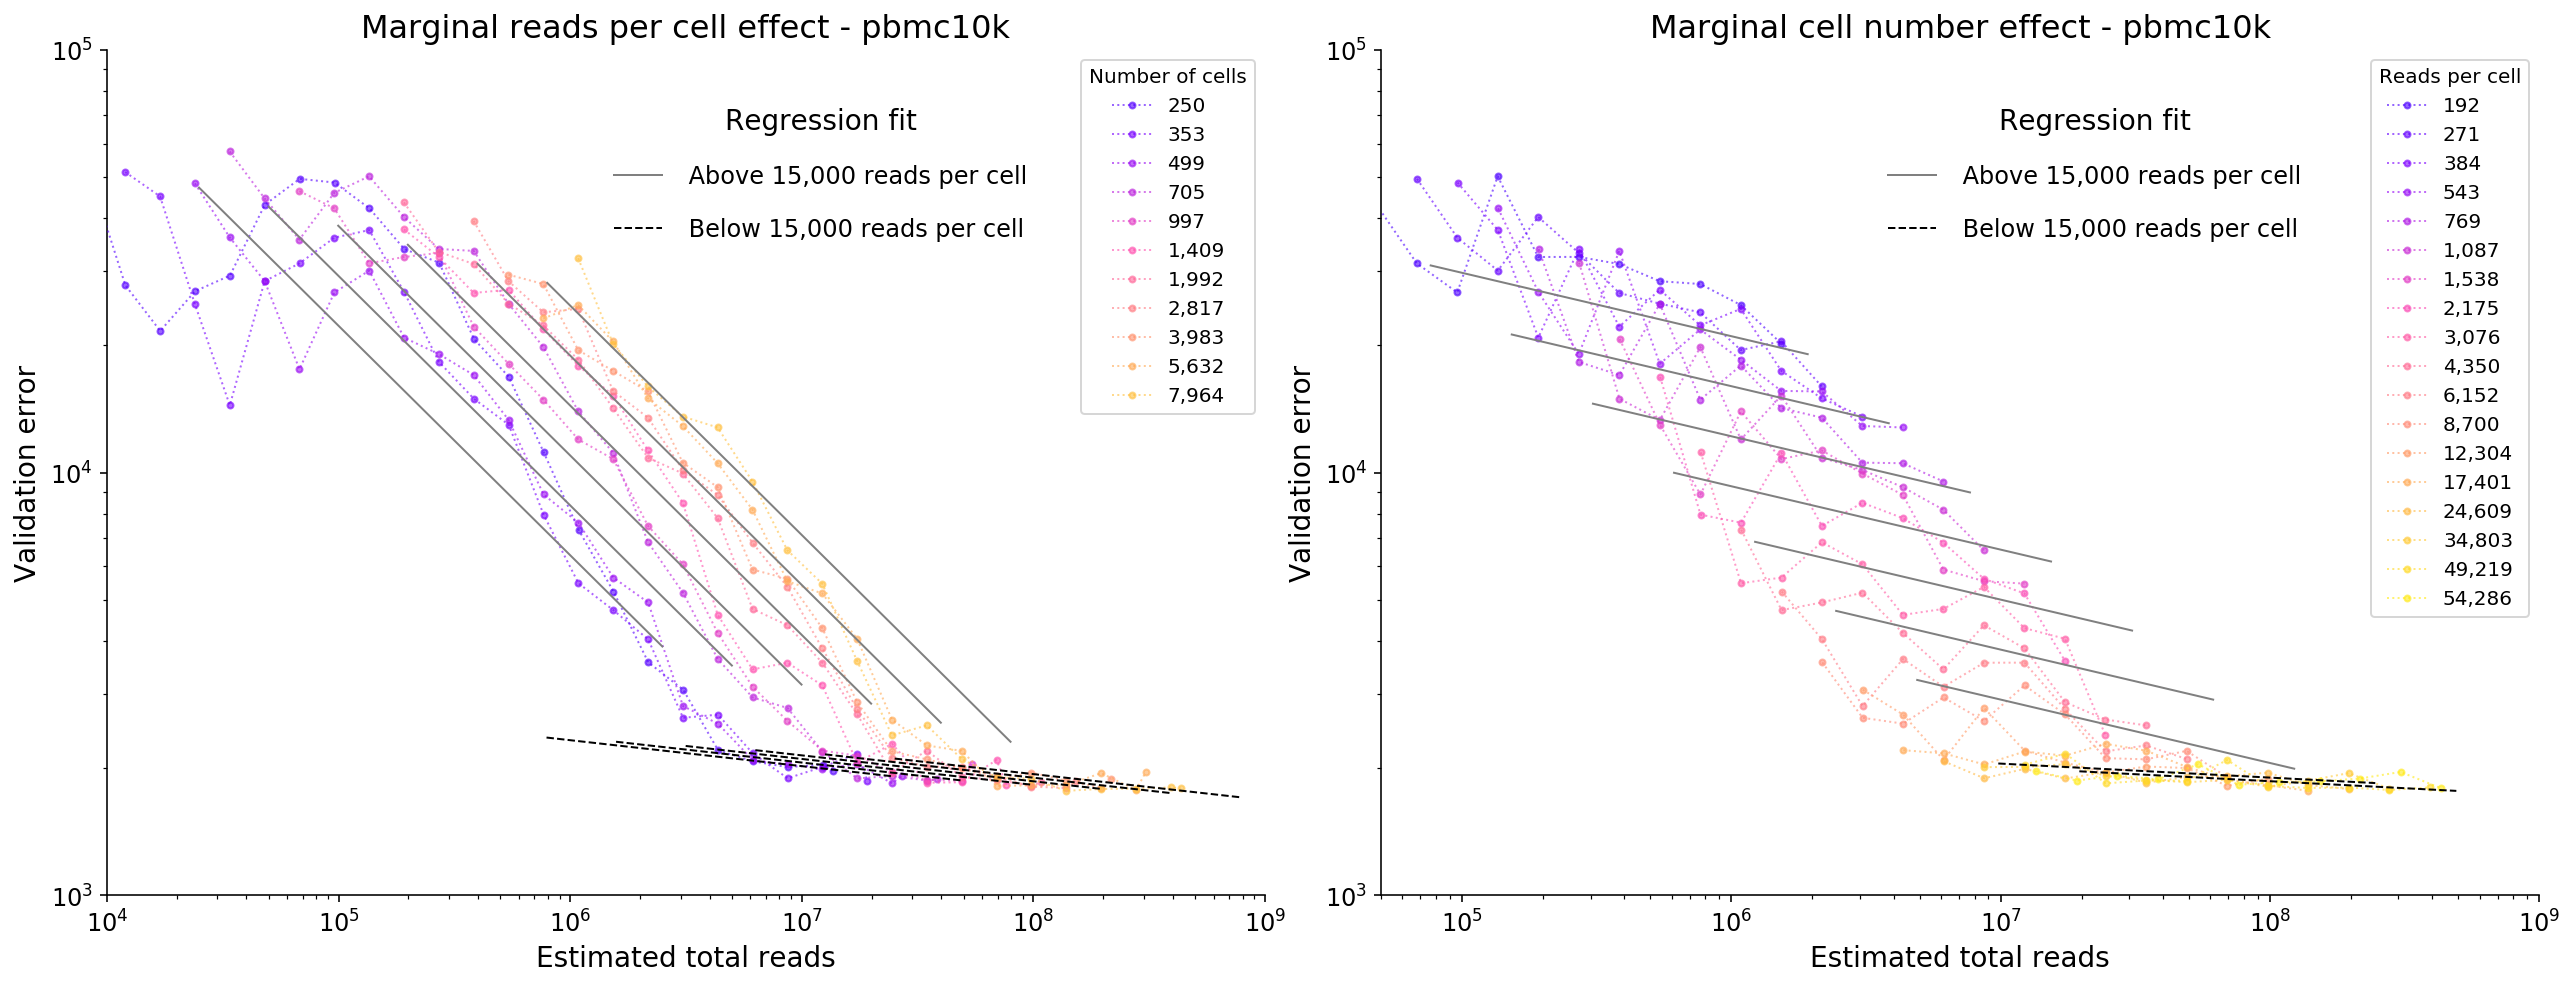

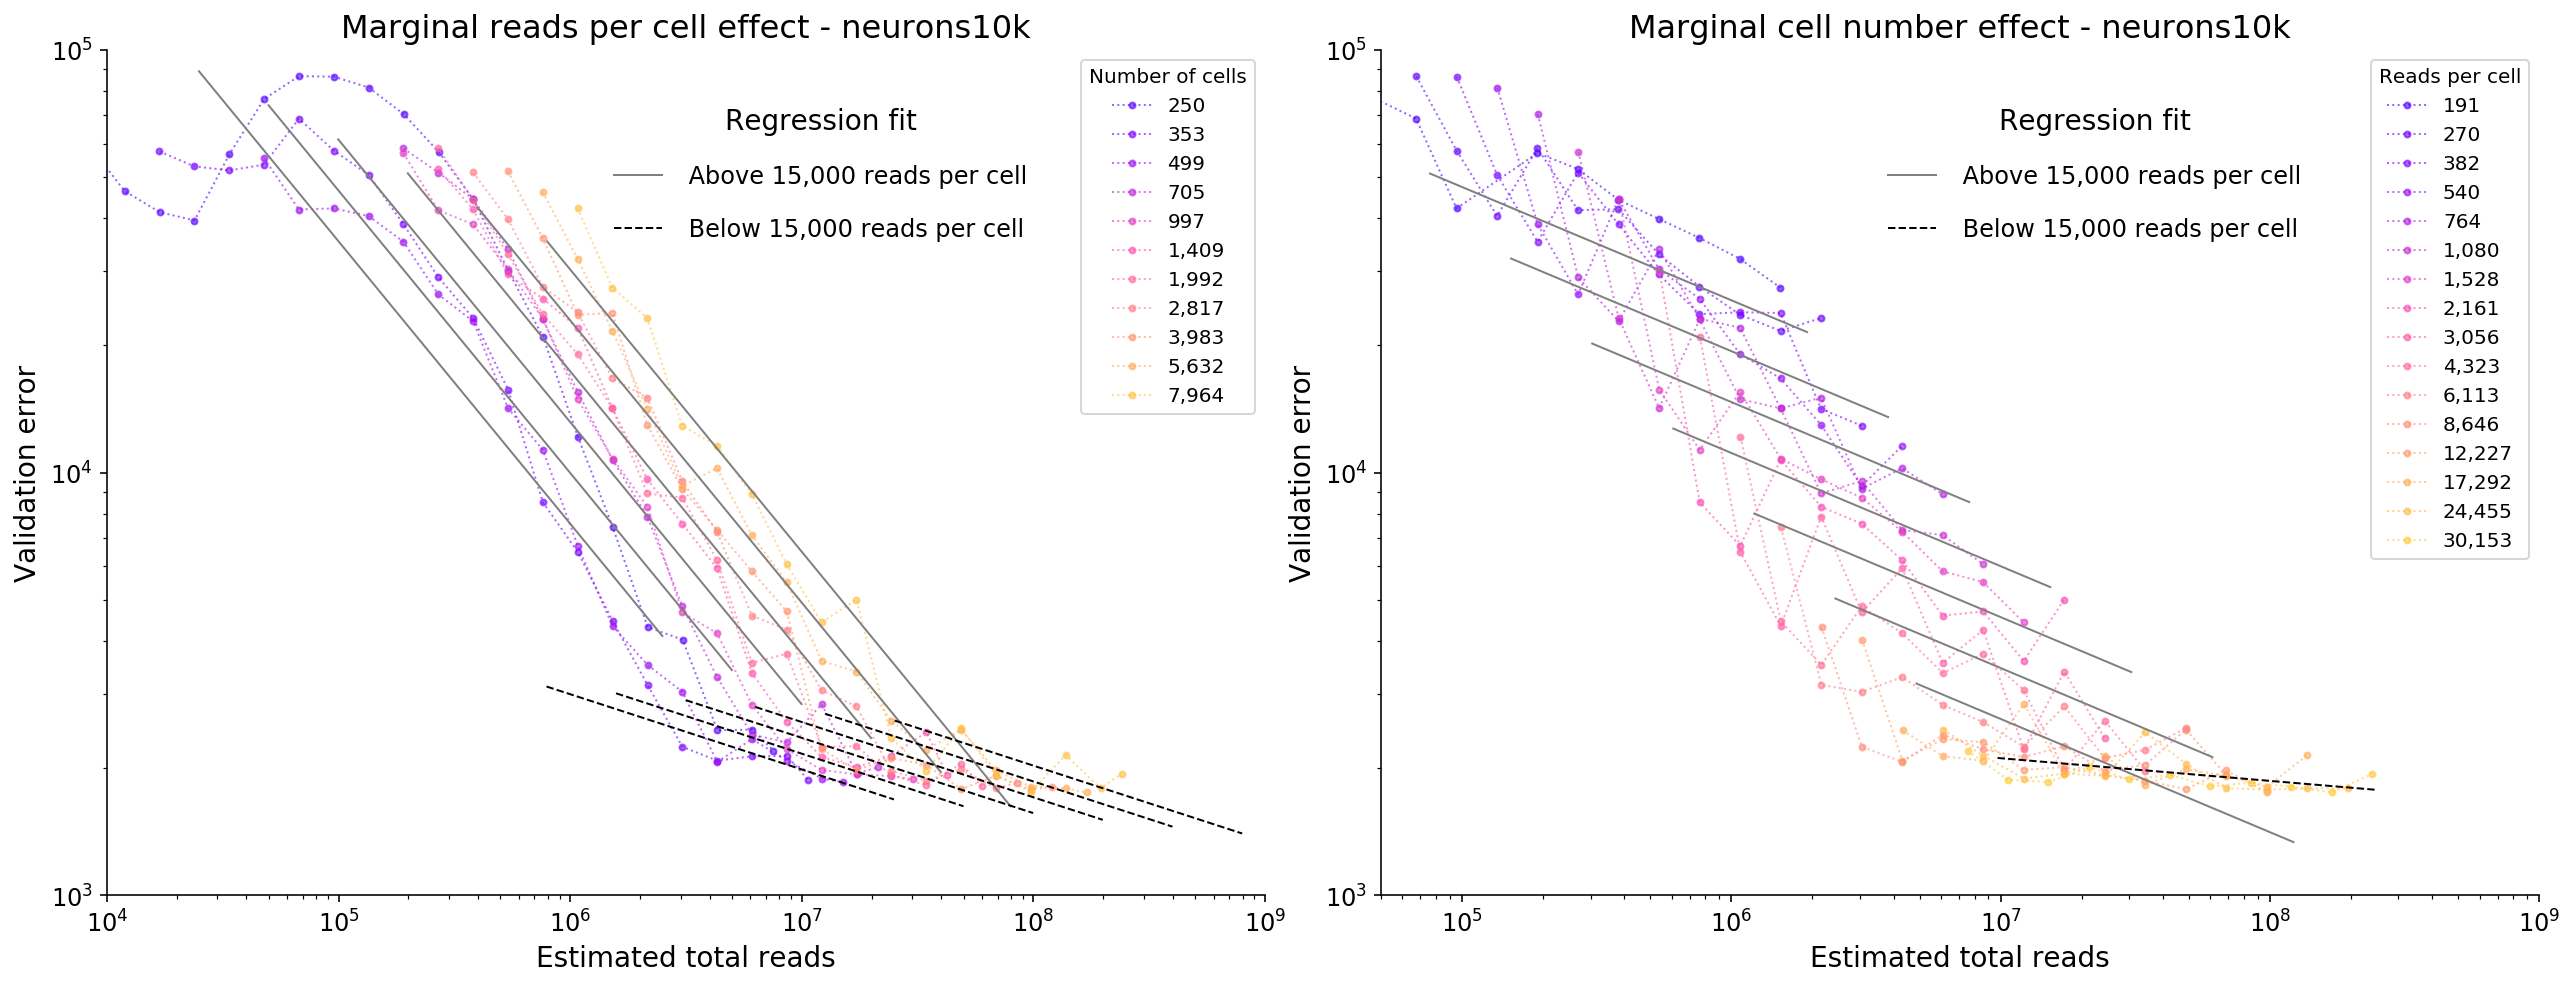

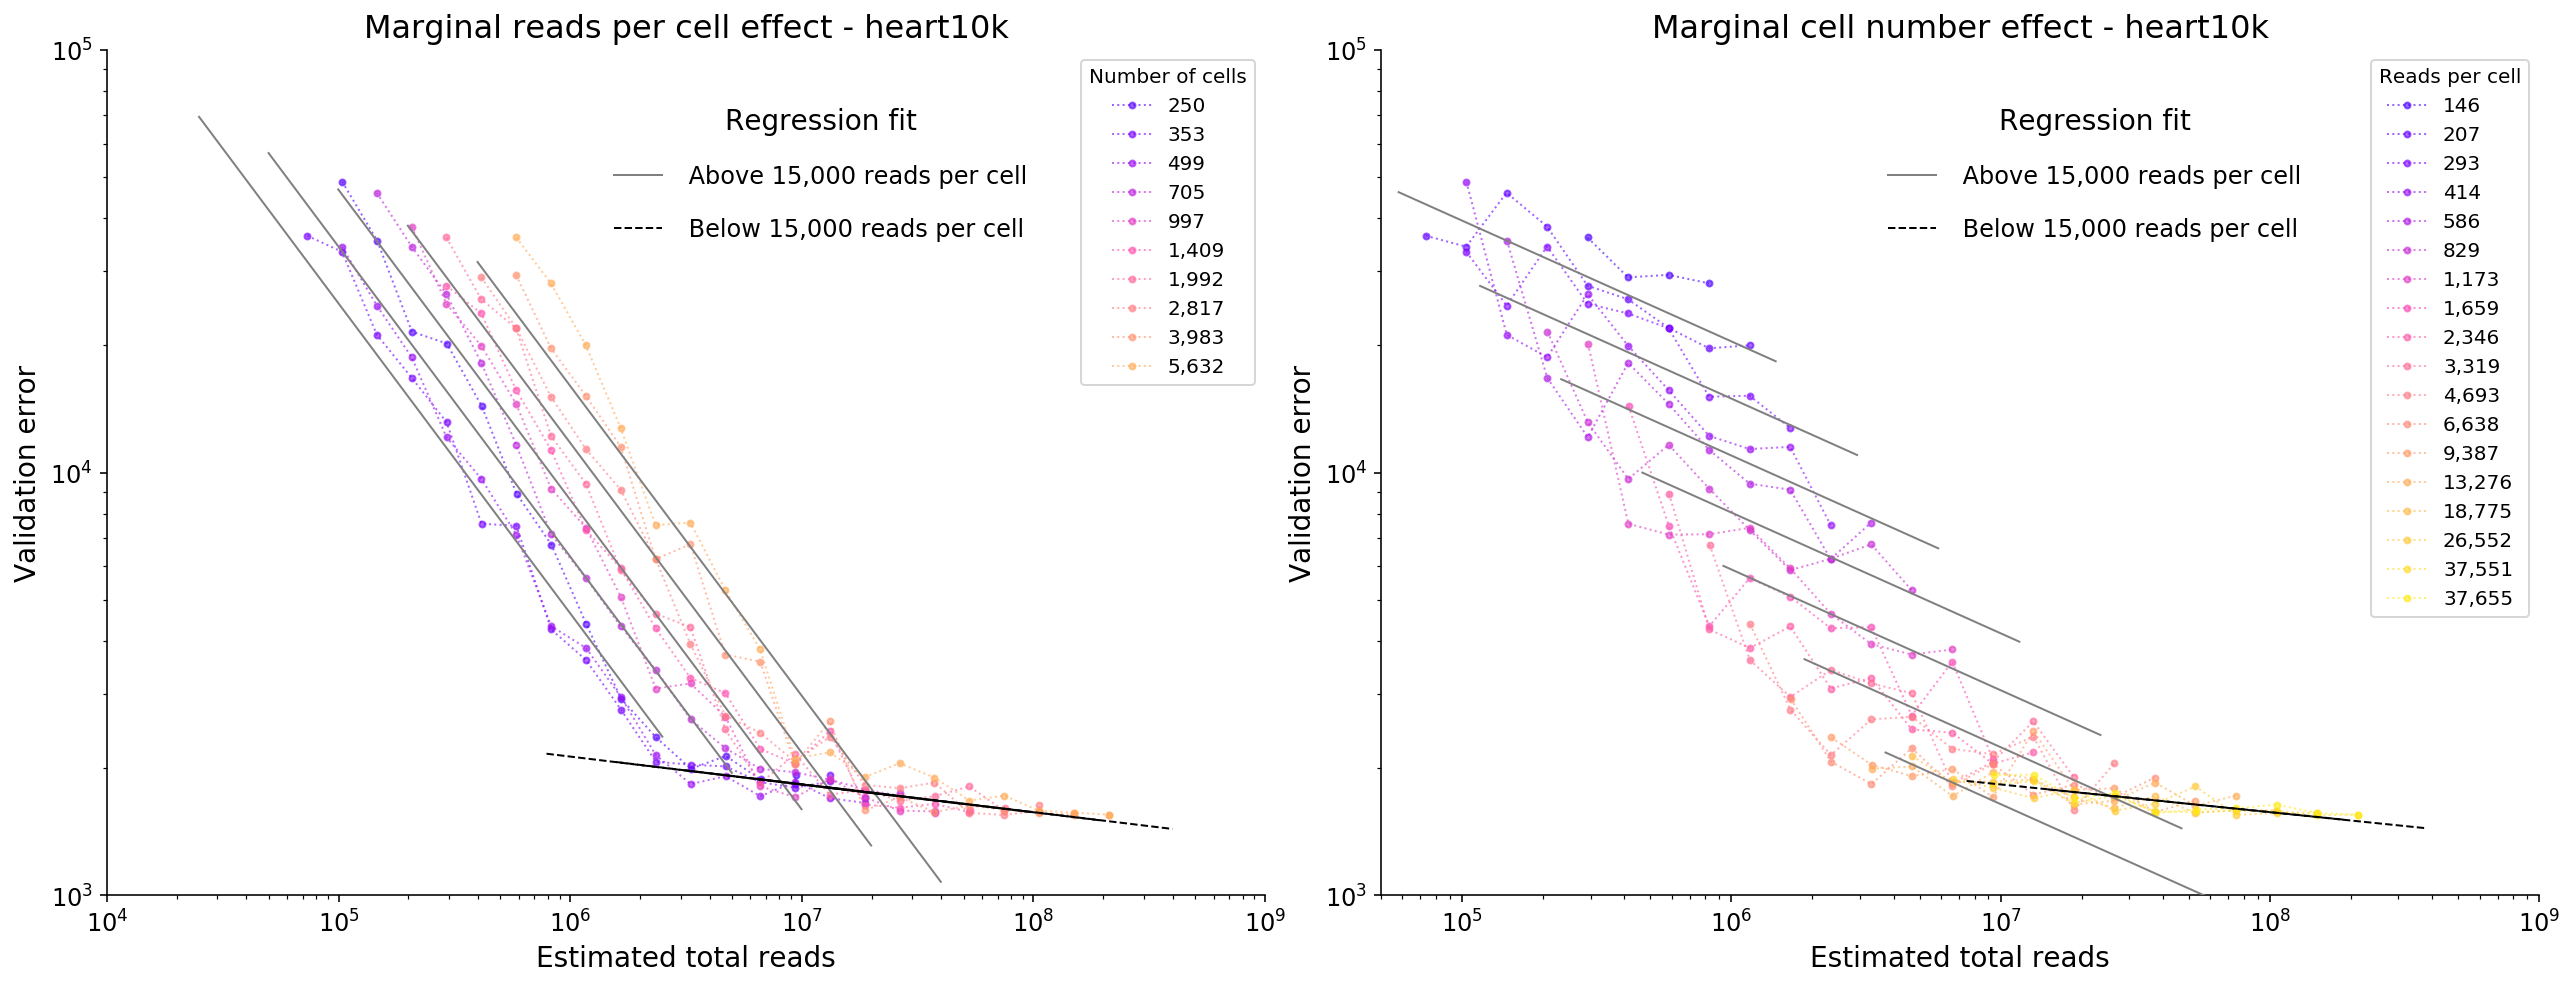

In [20]:
for ds in ['pbmc10k','neurons10k','heart10k']:
    plt.figure(figsize=(18, 7))
    
############################### FIRST FIGURE ####################    
    plt.subplot(1, 2, 2)
    i = 0
    for d_, grp_ in summary_results[ds].dropna().groupby('reads_per_cell'):
        c_offset = 10
        if d_ <= 144:
            continue            
        i += 1
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  
        grp_ = grp_.sort_values('estimated_reads').dropna()
        handle = plt.plot(
            grp_['estimated_reads'], grp_['validation_error'],
            zorder=3,
            marker='.',
            label=f'{d_:0,.0f}', 
            c= c_,
            ls=':',
            linewidth=1,
            alpha=0.6
        )[0]
    first_legend = plt.legend(scatterpoints=3, title='Reads per cell')

    flag = False
    i = 0
    rpc_values = pd.Series(
        summary_results[ds]
        .dropna()['reads_per_cell']
        .unique()).sort_values().values
    
    for reads_per_cell in rpc_values:

        if reads_per_cell <= 144:
            continue        
        c_offset = 10

        i = i + 1
        flag = not flag
        if not flag: continue

        if reads_per_cell > threshold: 
            model = reads_res_above[ds][threshold]
            ls = '--'
            modcol = 'black'
            tdf = pd.DataFrame({'sampled_cells': 10 ** np.linspace(2.6, 4)})
            tdf['reads_per_cell'] = reads_per_cell
            tdf['estimated_reads'] = tdf['reads_per_cell']*tdf['sampled_cells']
            tdf['validation_error'] =  2 ** model.predict(tdf)

            grp_ = tdf
            grp_ = grp_.sort_values('sampled_cells').dropna()

            c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  

            handle_above = plt.plot(
                grp_['estimated_reads'], grp_['validation_error'],
                zorder=3, 
                label=' Below 15,000 reads per cell',
                linewidth=1,
                ls=ls,
                c=modcol
            )[0]
            
            
        if reads_per_cell <= threshold: 
            model = reads_res_below[ds][threshold]
            ls = '-'
            modcol = 'gray'
            tdf = pd.DataFrame({'sampled_cells': 10 ** np.linspace(2.6, 4)})
            tdf['reads_per_cell'] = reads_per_cell
            tdf['estimated_reads'] = tdf['reads_per_cell']*tdf['sampled_cells']
            tdf['validation_error'] =  2 ** model.predict(tdf)

            grp_ = tdf
            grp_ = grp_.sort_values('sampled_cells').dropna()

            c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  

            handle_below = plt.plot(
                grp_['estimated_reads'], grp_['validation_error'],
                zorder=3, 
                label=' Above 15,000 reads per cell',
                linewidth=1,
                ls=ls,
                c=modcol
            )[0]

############### add legend   ######################

    ax = plt.gca().add_artist(first_legend)

    second_legend = plt.legend(
    handles=[handle_below, handle_above],
    loc='upper right',
    bbox_to_anchor=(0.83, 0.98),
    title='Regression fit',
    labelspacing=1.2,
    borderpad=1.2,
    fontsize=12,
    title_fontsize=14,
    frameon=False
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Estimated total reads')
    plt.ylabel('Validation error');
    plt.title('Marginal cell number effect - ' + ds)
    plt.tight_layout()
    plt.ylim(bottom=1e3, top=1e5)
    plt.xlim(left=5e4, right=1e9)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
############ SECOND PLOT #######
    plt.subplot(1, 2, 1)
    i = 0
    for d_, grp_ in summary_results[ds].dropna().groupby('sampled_cells'):
    
        c_offset = 10
        i += 1.4
        c_ = plt.cm.gnuplot2((i + c_offset) / (18 + c_offset + b_offset))  # ITS HERE
        grp_ = grp_.sort_values('estimated_reads').dropna()
        handle = plt.plot(
            grp_['estimated_reads'], grp_['validation_error'],
            zorder=3,
            marker='.',
            label=f'{d_:0,.0f}', 
            c= c_,
            ls=':',
            linewidth=1,
            alpha=0.6
        )[0]
        depths_handles.append(handle)
    first_legend = plt.legend(scatterpoints=3, title='Number of cells')

    for i, model in enumerate([reads_res_below[ds][threshold], reads_res_above[ds][threshold]]):
        ncell_values = pd.Series(summary_results[ds].dropna()['sampled_cells'].unique()).sort_values().values

        flag = False
        for ncells in ncell_values:
            flag = not flag
            if not flag:
                continue

            start = 2
            end = 4
            ls = '-'
            modcol = 'grey'
            if i > 0:
                start = 3.5
                end = 5
                ls = '--'
                modcol = 'black'

            tdf = pd.DataFrame({'reads_per_cell': 10 ** np.linspace(start, end)})
            tdf['sampled_cells'] = ncells
            tdf['validation_error'] = 2 ** model.predict(tdf)
            tdf['estimated_reads'] = tdf['reads_per_cell'] * tdf['sampled_cells']

            grp_ = tdf
            grp_ = grp_.sort_values('estimated_reads').dropna()
            handle = plt.plot(
                grp_['estimated_reads'], grp_['validation_error'],
                zorder=3,
                linewidth=1,
                ls=ls,
                color=modcol
            )[0]

            
    ############### add legend   ######################

    ax = plt.gca().add_artist(first_legend)

    second_legend = plt.legend(
    handles=[handle_below, handle_above],
    loc='upper right',
    bbox_to_anchor=(0.83, 0.98),
    title='Regression fit',
    labelspacing=1.2,
    borderpad=1.2,
    fontsize=12,
    title_fontsize=14,
    frameon=False
    )
        
        
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Estimated total reads')
    plt.ylabel('Validation error');
    plt.title('Marginal reads per cell effect - ' + ds )
    plt.ylim(bottom=1e3, top=1e5);
    plt.tight_layout()
    plt.ylim(bottom=1e3, top=1e5)
    plt.xlim(left=1e4, right=1e9)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    
    plt.savefig(figfolder + 'main_models-marginal-effect_' + ds + '.pdf', bbox_inches='tight')

# Make models for different threshold and summarize results
This table is shown in the supplements

In [21]:
threshold_list = [1000, 2000,5000, 10000,12000, 15000, 18000, 20000, 25000]
mod_below = {}
res_below = {}
mod_above = {}
res_above = {}
statsmodels_summary = pd.DataFrame()

for ds in datasets:
    mod_below[ds] = {}
    res_below[ds] = {}
    mod_above[ds] = {}
    res_above[ds] = {}    
    
    for threshold in threshold_list: 
    
        mod_below[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(reads_per_cell)', 
                                          data=summary_results[ds].query('reads_per_cell < @threshold').dropna())
        res_below[ds][threshold] = mod_below[ds][threshold].fit()

        results_ = pd.DataFrame.from_dict(
            {
                'dataset': ds,
                'modelkind': 'below',
                'threshold': threshold,
                'params': res_below[ds][threshold].params,
                'pvalue': res_below[ds][threshold].pvalues,
                'rsquared': res_below[ds][threshold].rsquared
            }
        )
        statsmodels_summary = statsmodels_summary.append(results_)

        mod_above[ds][threshold] = smf.ols(formula='np.log2(validation_error) ~ np.log2(sampled_cells) + np.log2(reads_per_cell)', 
                                          data=summary_results[ds].query('reads_per_cell >= @threshold').dropna())
        res_above[ds][threshold] = mod_above[ds][threshold].fit()

        results_ = pd.DataFrame.from_dict(
            {
                'dataset':ds,
                'modelkind': 'above',
                'threshold': threshold,
                'params': res_above[ds][threshold].params,
                'pvalue': res_above[ds][threshold].pvalues,
                'rsquared': res_above[ds][threshold].rsquared
            }
        )
        statsmodels_summary = statsmodels_summary.append(results_)    
    
statsmodels_summary['exp_param'] = statsmodels_summary['params'].pipe(lambda s: 2 ** s)
    
statsmodels_summary.head()

dataset modelkind  threshold     params  \
Intercept                heart10k     below       1000  25.923752   
np.log2(sampled_cells)   heart10k     below       1000  -0.380115   
np.log2(reads_per_cell)  heart10k     below       1000  -0.920594   
Intercept                heart10k     above       1000  17.551767   
np.log2(sampled_cells)   heart10k     above       1000  -0.188859   

                               pvalue  rsquared     exp_param  
Intercept                5.145936e-44  0.911263  6.365420e+07  
np.log2(sampled_cells)   1.772814e-19  0.911263  7.683762e-01  
np.log2(reads_per_cell)  5.420524e-26  0.911263  5.282915e-01  
Intercept                2.076768e-78  0.734642  1.921359e+05  
np.log2(sampled_cells)   3.415332e-12  0.734642  8.772991e-01

In [22]:
effect_summaries = statsmodels_summary.reset_index().rename(columns={'index': 'parameter'}).query('parameter != "Intercept"')
def renamer(s):
    if 'sampled' in s:
        return 'Cells'
    
    if 'reads' in s:
        return 'Depth'

effect_summaries['effect_name'] = effect_summaries['parameter'].map(renamer)
effect_summaries['marginal_percent'] = effect_summaries['exp_param'].map(lambda s: f'{s:.0%}')

In [23]:
effect_summaries

parameter   dataset modelkind  threshold    params  \
1     np.log2(sampled_cells)  heart10k     below       1000 -0.380115   
2    np.log2(reads_per_cell)  heart10k     below       1000 -0.920594   
4     np.log2(sampled_cells)  heart10k     above       1000 -0.188859   
5    np.log2(reads_per_cell)  heart10k     above       1000 -0.340224   
7     np.log2(sampled_cells)  heart10k     below       2000 -0.398215   
..                       ...       ...       ...        ...       ...   
155  np.log2(reads_per_cell)   pbmc10k     above      20000 -0.012306   
157   np.log2(sampled_cells)   pbmc10k     below      25000 -0.137335   
158  np.log2(reads_per_cell)   pbmc10k     below      25000 -0.545230   
160   np.log2(sampled_cells)   pbmc10k     above      25000 -0.027531   
161  np.log2(reads_per_cell)   pbmc10k     above      25000 -0.016901   

           pvalue  rsquared  exp_param effect_name marginal_percent  
1    1.772814e-19  0.911263   0.768376       Cells              77%  
2    5.420524e-26  0.911263   0.528292       Depth              53%  
4    3.415332e-12  0.734642   0.877299       Cells              88%  
5    9.457574e-32  0.734642   0.789919       Depth              79%  
7    4.830326e-26  0.936701   0.758797       Cells              76%  
..            ...       ...        ...         ...              ...  
155  5.134026e-01  0.390038   0.991507       Depth              99%  
157  1.475711e-08  0.899158   0.909197       Cells              91%  
158  1.208066e-93  0.899158   0.685282       Depth              69%  
160  2.384892e-04  0.369647   0.981098       Cells              98%  
161  6.587692e-01  0.369647   0.988353       Depth              99%  

[108 rows x 10 columns]

In [24]:
all_summaries_rsquared = pd.pivot_table(
    effect_summaries,
    values='rsquared',
    columns=['modelkind', 'effect_name', 'threshold'],
    index='dataset',
)[['below', 'above']].round(2).T.add_suffix('_R2')
all_summaries_rsquared

dataset                          heart10k_R2  neurons10k_R2  pbmc10k_R2
modelkind effect_name threshold                                        
below     Cells       1000              0.91           0.56        0.49
                      2000              0.94           0.65        0.64
                      5000              0.95           0.78        0.78
                      10000             0.94           0.84        0.84
                      12000             0.94           0.84        0.84
                      15000             0.93           0.86        0.87
                      18000             0.93           0.87        0.89
                      20000             0.91           0.87        0.89
                      25000             0.91           0.88        0.90
          Depth       1000              0.91           0.56        0.49
                      2000              0.94           0.65        0.64
                      5000              0.95           0.78        0.78
                      10000             0.94           0.84        0.84
                      12000             0.94           0.84        0.84
                      15000             0.93           0.86        0.87
                      18000             0.93           0.87        0.89
                      20000             0.91           0.87        0.89
                      25000             0.91           0.88        0.90
above     Cells       1000              0.73           0.79        0.84
                      2000              0.67           0.69        0.77
                      5000              0.64           0.51        0.65
                      10000             0.69           0.41        0.52
                      12000             0.69           0.41        0.52
                      15000             0.72           0.41        0.48
                      18000             0.72           0.39        0.39
                      20000             0.67           0.39        0.39
                      25000             0.67           0.34        0.37
          Depth       1000              0.73           0.79        0.84
                      2000              0.67           0.69        0.77
                      5000              0.64           0.51        0.65
                      10000             0.69           0.41        0.52
                      12000             0.69           0.41        0.52
                      15000             0.72           0.41        0.48
                      18000             0.72           0.39        0.39
                      20000             0.67           0.39        0.39
                      25000             0.67           0.34        0.37

In [25]:
all_summaries_effect = pd.pivot_table(
    effect_summaries,
    values='exp_param',
    columns=['modelkind', 'effect_name', 'threshold'],
    index='dataset',
)[['below', 'above']].round(2).T

In [26]:
# show marginal effects for different thresholds
all_summaries_effect 

dataset                          heart10k  neurons10k  pbmc10k
modelkind effect_name threshold                               
below     Cells       1000           0.77        0.82     0.90
                      2000           0.76        0.81     0.89
                      5000           0.78        0.81     0.89
                      10000          0.81        0.83     0.90
                      12000          0.81        0.83     0.90
                      15000          0.82        0.83     0.90
                      18000          0.82        0.84     0.91
                      20000          0.83        0.84     0.91
                      25000          0.83        0.84     0.91
          Depth       1000           0.53        0.87     0.87
                      2000           0.52        0.76     0.80
                      5000           0.55        0.66     0.73
                      10000          0.58        0.63     0.69
                      12000          0.58        0.63     0.69
                      15000          0.60        0.63     0.69
                      18000          0.60        0.63     0.68
                      20000          0.62        0.63     0.68
                      25000          0.62        0.64     0.69
above     Cells       1000           0.88        0.83     0.89
                      2000           0.91        0.87     0.91
                      5000           0.95        0.93     0.95
                      10000          0.96        0.95     0.97
                      12000          0.96        0.95     0.97
                      15000          0.96        0.96     0.98
                      18000          0.96        0.97     0.98
                      20000          0.96        0.97     0.98
                      25000          0.96        0.98     0.98
          Depth       1000           0.79        0.66     0.72
                      2000           0.85        0.72     0.76
                      5000           0.93        0.85     0.87
                      10000          0.95        0.92     0.94
                      12000          0.95        0.92     0.94
                      15000          0.96        0.88     0.96
                      18000          0.96        0.86     0.99
                      20000          0.97        0.86     0.99
                      25000          0.97        1.68     0.99

In [27]:
final_summary = pd.concat([all_summaries_effect, all_summaries_rsquared], axis = 1)

In [28]:
final_summary

dataset                          heart10k  neurons10k  pbmc10k  heart10k_R2  \
modelkind effect_name threshold                                               
below     Cells       1000           0.77        0.82     0.90         0.91   
                      2000           0.76        0.81     0.89         0.94   
                      5000           0.78        0.81     0.89         0.95   
                      10000          0.81        0.83     0.90         0.94   
                      12000          0.81        0.83     0.90         0.94   
                      15000          0.82        0.83     0.90         0.93   
                      18000          0.82        0.84     0.91         0.93   
                      20000          0.83        0.84     0.91         0.91   
                      25000          0.83        0.84     0.91         0.91   
          Depth       1000           0.53        0.87     0.87         0.91   
                      2000           0.52        0.76     0.80         0.94   
                      5000           0.55        0.66     0.73         0.95   
                      10000          0.58        0.63     0.69         0.94   
                      12000          0.58        0.63     0.69         0.94   
                      15000          0.60        0.63     0.69         0.93   
                      18000          0.60        0.63     0.68         0.93   
                      20000          0.62        0.63     0.68         0.91   
                      25000          0.62        0.64     0.69         0.91   
above     Cells       1000           0.88        0.83     0.89         0.73   
                      2000           0.91        0.87     0.91         0.67   
                      5000           0.95        0.93     0.95         0.64   
                      10000          0.96        0.95     0.97         0.69   
                      12000          0.96        0.95     0.97         0.69   
                      15000          0.96        0.96     0.98         0.72   
                      18000          0.96        0.97     0.98         0.72   
                      20000          0.96        0.97     0.98         0.67   
                      25000          0.96        0.98     0.98         0.67   
          Depth       1000           0.79        0.66     0.72         0.73   
                      2000           0.85        0.72     0.76         0.67   
                      5000           0.93        0.85     0.87         0.64   
                      10000          0.95        0.92     0.94         0.69   
                      12000          0.95        0.92     0.94         0.69   
                      15000          0.96        0.88     0.96         0.72   
                      18000          0.96        0.86     0.99         0.72   
                      20000          0.97        0.86     0.99         0.67   
                      25000          0.97        1.68     0.99         0.67   

dataset                          neurons10k_R2  pbmc10k_R2  
modelkind effect_name threshold                             
below     Cells       1000                0.56        0.49  
                      2000                0.65        0.64  
                      5000                0.78        0.78  
                      10000               0.84        0.84  
                      12000               0.84        0.84  
                      15000               0.86        0.87  
                      18000               0.87        0.89  
                      20000               0.87        0.89  
                      25000               0.88        0.90  
          Depth       1000                0.56        0.49  
                      2000                0.65        0.64  
                      5000                0.78        0.78  
                      10000               0.84        0.84  
                      12000               0.84        0.84  
                     

In [29]:
%load_ext watermark

In [30]:
%watermark

2019-09-07T17:01:10-07:00

CPython 3.7.3
IPython 7.6.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-957.27.2.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 88
interpreter: 64bit


In [31]:
%watermark -iv

anndata     0.6.22.post1
statsmodels 0.10.1
pandas      0.25.1
plotnine    0.6.0
matplotlib  3.1.1
numpy       1.16.4
scipy       1.3.0

